In [4]:
import igraph
import elpigraph
import numpy as np
import os
from os import path

import seaborn as sns

from importlib import reload  
import clintraj_eltree
import clintraj_util
import clintraj_ml
import clintraj_optiscale

from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
from clintraj_eltree import project_on_tree,visualize_eltree_with_data,partition_data_by_tree_branches,prune_the_tree
from clintraj_eltree import ExtendLeaves_modified,regression_of_variable_with_trajectories
from clintraj_eltree import draw_pseudotime_dependence, add_pie_charts
from clintraj_util import associate_with_categorical_var, get_matrix_of_association_scores, get_standard_color_seq, remove_constant_columns_from_dataframe
from clintraj_util import brokenstick_distribution
from clintraj_qi import detect_variable_type
from clintraj_optiscale import optimal_scaling

from clintraj_ml import apply_panel_of_manifold_learning_methods

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression


    


/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
Using TensorFlow backend.
/home/zinovyev/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zinovyev/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zinovyev/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated;

In [3]:
# Loading data

#file = 'data/infarction/all_dummies_q_imp_SVDcomplete.txt'
dataset_name = 'diabete'
#file = 'data/diabetis/sample_1/'+dataset_name+'.txt'
#color_file = 'data/diabetis/sample_1/classes_sequence.txt'
#file = 'data/diabetis/diabetic_numerical_sample1.txt'
#file = 'data/diabetis/diabete_sample.txt'
file = 'data/diabetis/diabete_glr_sample_imp_SVDcomplete.txt'
color_file = 'data/diabetis/class_sequence_sample.txt'
annotation_file = 'data/diabetis/diabete_annot_sample.txt'
file = 'data/diabetis/diabete_glr_imp_SVDcomplete.txt'
color_file = 'data/diabetis/class_sequence.txt'
annotation_file = 'data/diabetis/diabete_annot.txt'
#file = 'data/diabetis/diabete_A1C.txt'
#color_file = 'data/diabetis/class_sequence_A1C.txt'

df = pd.read_csv(file,delimiter='\t')
df = remove_constant_columns_from_dataframe(df)
#df.drop(['readmitted'],axis=1,inplace=True)
#df.drop(['A1Cresult_None'],axis=1,inplace=True)
#df.drop(['max_glu_serum_None'],axis=1,inplace=True)

variable_names = [str(s) for s in df.columns[1:]]
variable_types, binary, continuous, ordinal = detect_variable_type(df,5,verbose=False)
variable_types[variable_names.index('age')] = 'ORDINAL'
print('Var types=',variable_types)
X = df[df.columns[1:]].to_numpy()
X_original = X

with open(color_file) as fid:
    lines = fid.readlines()
color = np.ones(len(lines),'int32')
for i,line in enumerate(lines):
    color[i]=int(line.strip('\n'))
    
annotation_data = pd.read_csv(annotation_file,delimiter='\t')
    
viz_results={}

print(variable_names)

Removing  0 columns
Var types= ['CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'BINARY', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'ORDINAL']
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age', 'A1Cresult_None', 'A1Cresult_val', 'change_Ch', 'diabetesMed_Yes', 'metformin_treatment', 'metformin_treatment_change', 'glipizide_treatment', 'glipizide_treatment_change', 'glyburide_treatment', 'glyburide_treatment_change', 'insulin_treatment', 'insulin_treatment_change', 'readmitted']


In [4]:
# Starting from pre-saved dataset, after this one can go directly to reducing dimension via PCA
X = np.load(dataset_name+'_X_processed.npy')
print(X.shape)
cik = np.load(dataset_name+'_cik.npy',allow_pickle=True)


(99343, 22)


In [188]:
# Pre-processing the data
X = X[:,np.where(np.std(X,axis=0)>0)[0]]
print('Shape of the data matrix:',X.shape)

if 'X_before_scaling' in locals():
    del X_before_scaling

Shape of the data matrix: (99343, 22)



 Initial Q2: 3.235317763363314
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 3.235317763363314
Iteration 1 Q2= 3.2353177633632946
Iteration 2 Q2= 3.2610341943707297
Iteration 3 Q2= 3.265451201327579
Iteration 4 Q2= 3.2668838077455895
Iteration 5 Q2= 3.2673923253841686
Iteration 6 Q2= 3.2675787312388778
Iteration 7 Q2= 3.2676478703969707
Iteration 8 Q2= 3.267673626587994
Iteration 9 Q2= 3.267683237043075
Iteration 10 Q2= 3.2676868251814
Iteration 11 Q2= 3.2676881651436034
Iteration 12 Q2= 3.2676886655842416
Iteration 13 Q2= 3.267688852491549
Iteration 14 Q2= 3.2676889222995484
Iteration 15 Q2= 3.2676889483722444
Iteration 16 Q2= 3.2676889581101882

 Q2 after update: 3.267688963105641
Final quantification table:
[array([-2.74342703, -2.34068845, -1.92740426, -1.55284805, -1.27

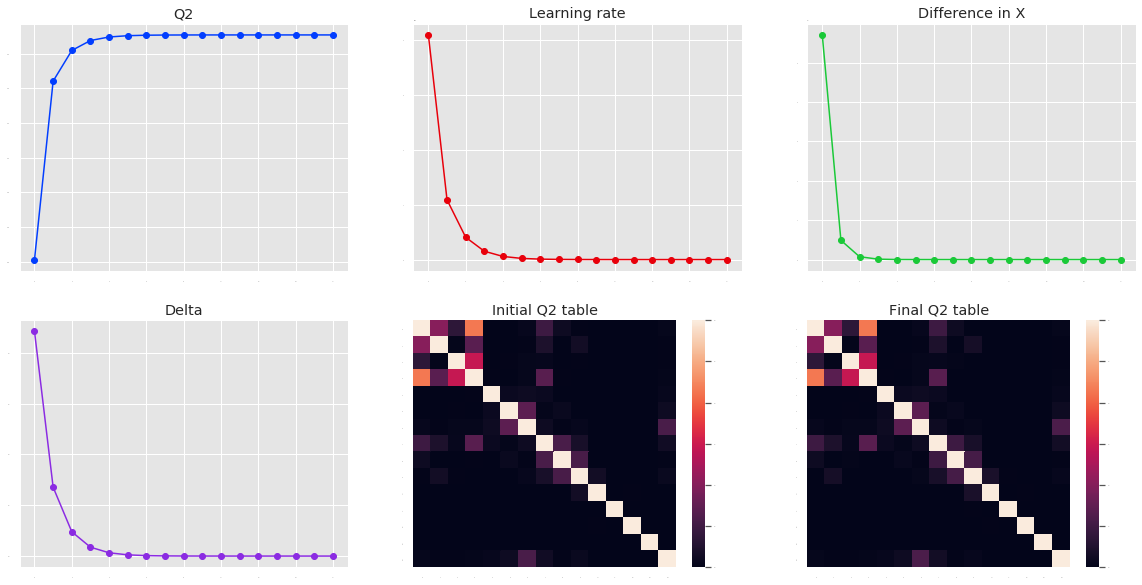

In [62]:
# Apply optimal scaling
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.3,fraction_max_step=0.9,max_num_iterations=100)

In [63]:
# saving the pre-processed data and encoding table

np.save(dataset_name+'_X_processed.npy',X)
np.save(dataset_name+'_cik.npy',cik)

FVE PC1 0.12426972634569423 FVE PC2 0.09144839709446648
FVE PC1 in retained dimensions 0.27316365250037566 FVE PC2 in retained dimensions 0.20101740705647528
Explained variance: [0.12426973 0.21571812 0.28596398 0.34664453 0.40286727 0.45492775
 0.50589033 0.55223324 0.59783575 0.64238187 0.68578777 0.72864091
 0.76890698 0.8048463  0.83973664 0.87096411 0.90018619 0.92808775
 0.95096064 0.97299104 0.98990879 1.        ]
[0.27316365 0.47418106 0.62859207 0.76197711 0.88556318 1.        ]


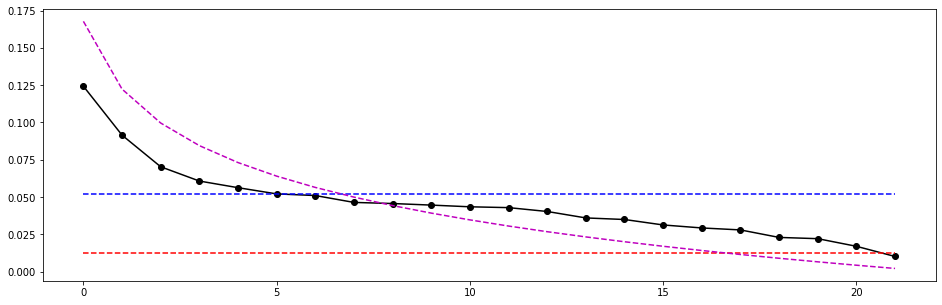

In [5]:
# reducing dimension via PCA
initial_dimension = 6

X = scipy.stats.zscore(X)

pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
s = pca.explained_variance_ratio_
print('FVE PC1',s[0]/np.sum(s),'FVE PC2',s[1]/np.sum(s))
print('FVE PC1 in retained dimensions',s[0]/np.sum(s[0:initial_dimension]),'FVE PC2 in retained dimensions',s[1]/np.sum(s[0:initial_dimension]))
v = pca.components_.T
mean_val = np.mean(X,axis=0)

if 'X_before_scaling' in locals():
    X_before_scaling = scipy.stats.zscore(X_before_scaling)
    Ybs = pca.fit_transform(X_before_scaling)
    sbs = pca.explained_variance_ratio_
    vbs = pca.components_.T
    
fig = plt.figure(figsize=(16,5))
if 'X_before_scaling' in locals():
    plt.plot(sbs,'go-')
plt.plot(s,'ko-')
plt.plot([0,X.shape[1]-1],[s[0]/10,s[0]/10],'r--')
plt.plot([0,X.shape[1]-1],[s[initial_dimension-1],s[initial_dimension-1]],'b--')
plt.plot(brokenstick_distribution(len(s)),'m--')

print('Explained variance:',np.cumsum(s))

X = Y[:,0:initial_dimension]

# this is for applying ELMAP in MATLAB
ElMapFolder = '/mnt/c/MyPrograms/__github/ElMap'
if os.path.exists(ElMapFolder+'/tests/'):
    np.savetxt(ElMapFolder+'/tests/'+'_input.txt', X, delimiter="\t")

print(np.cumsum(s[0:initial_dimension]/np.sum(s[0:initial_dimension])))
    
plt.savefig(dataset_name+'_scree_plot.png', format='png', dpi=300)

In [6]:
# Changing class colors for visualization

if True:
    clrs = []
    for c in color:
        if c==0:
            clrs.append('k')
        if c==1:
            clrs.append('b')
        if c==2:
            clrs.append('r')
    color = clrs

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
6 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  99343  points and  6  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|7||50	4.267	50	49	31	7	0	0	3.5657	3.5532	0.6437	0.645	0.6904	0.011	0.5475	27.3761	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
446.3715  seconds elapsed


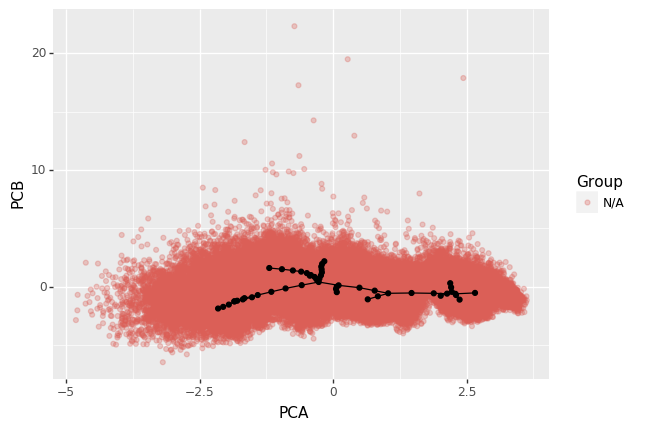

[<ggplot: (8734366250537)>]
Removed 3 vertices and 3 edges
12 labels generated


In [118]:
# Construct and post-process the principal tree

nnodes = 50

tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,drawPCAView=True,alpha=0.01,Mu=0.1,Lambda=0.05,FinalEnergy='Penalized')
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_extended['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

In [306]:
# Serialize the results if needed, for repeatitive use
import pickle as pkl
with open(dataset_name+'_dim'+str(X.shape[1])+'_tree_extended.pickle', 'wb') as handle:
    pkl.dump(tree_extended, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X.pickle', 'wb') as handle:
    pkl.dump(X, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X_original.pickle', 'wb') as handle:
    pkl.dump(X_original, handle,protocol=pkl.HIGHEST_PROTOCOL)


In [7]:
# Loading the data space and the constructed tree
import pickle as pkl
with open(dataset_name+'_dim'+str(X.shape[1])+'_tree_extended.pickle','rb') as handle:
    tree_extended = pkl.load(handle)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X.pickle','rb') as handle:
    X = pkl.load(handle)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X_original.pickle','rb') as handle:
    X_original = pkl.load(handle)
    
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
nodep = tree_extended['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]


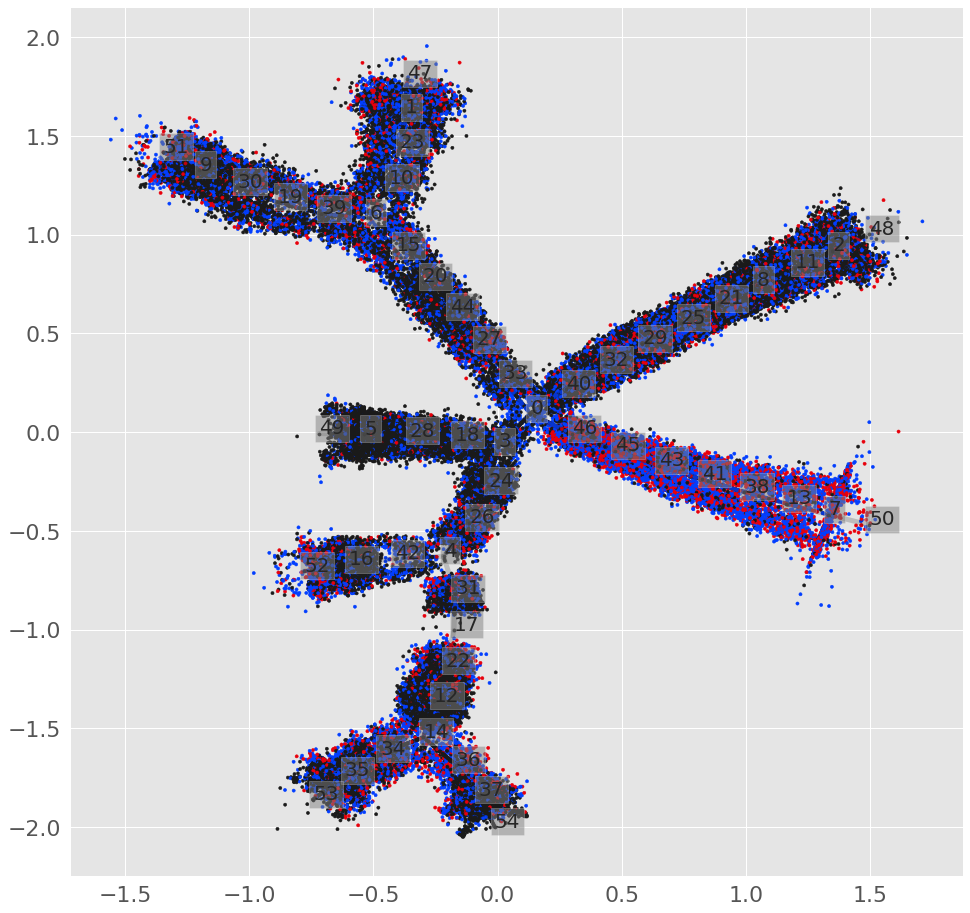

In [8]:
showEdgeNumbers=False
showNodeNumbers=True
showBranchNumbers=False
showPointNumbers=False
Color_by_feature = ''
Feature_Edge_Width = ''
Invert_Edge_Value = False
Min_Edge_Width = 5
Max_Edge_Width = 5
Big_Point_Size = 1000
Small_Point_Size = 100
Normal_Point_Size = 10
Visualize_Edge_Width_AsNodeCoordinates=False
Color_by_partitioning = False
Transparency_Alpha = 0.2
Visualize_Branch_Class_Associations = [] #list_of_branch_class_associations
cmap = 'hot'
highlight_subset = []
Color_by_partitioning=False
partitioning = vec_labels_by_branches
scatter_parameter = 0.05

sns.set(palette='bright',font_scale=2)

#feature = 'LET_IS_0'
feature = ''
fig = plt.figure(figsize=(16, 16))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,Color_by_feature=feature, Feature_Edge_Width=feature,Invert_Edge_Value=Invert_Edge_Value,Min_Edge_Width=Min_Edge_Width,Max_Edge_Width=Max_Edge_Width,Visualize_Edge_Width_AsNodeCoordinates=Visualize_Edge_Width_AsNodeCoordinates, Color_by_partitioning=Color_by_partitioning, visualize_partition=partitioning, showBranchNumbers=showBranchNumbers,showNodeNumbers=showNodeNumbers,scatter_parameter=scatter_parameter,cmap=cmap,Normal_Point_Size=Normal_Point_Size,highlight_subset=highlight_subset,Big_Point_Size=Big_Point_Size,showPointNumbers=showPointNumbers,Visualize_Branch_Class_Associations=Visualize_Branch_Class_Associations)
plt.savefig(dataset_name+'_principal_tree.png', format='png', dpi=300)

In [9]:
# Associate nodes (vec_labels_by_branches) and classes (color)
# The aim is to identify the root_node (the node most enriched with 'k' class - which means no complications)

Negative_Enrichment = False
Threshold_Deviation = 0.2
Minimal_number_of_points = 20
partitioning = partition_by_node
#partitioning = vec_labels_by_branches
#partitioning = color

list_of_node_class_associations,p,stat = associate_with_categorical_var(partitioning,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                                       produce_plot=False)
    
print(list_of_node_class_associations)

k_nodes_scores = [(asst[0],asst[2]) for asst in list_of_node_class_associations if asst[1]=='k']
if len(k_nodes_scores)>0:
    max_score_node = int(k_nodes_scores[np.argmax([t[1] for t in k_nodes_scores])][0])
else:
    max_score_node = 0

root_node = max_score_node

print('Suggested root_node=',root_node)
root_node = 12
print('Selected root_node=',root_node)

[(0.0, 'b', 0.22307763796726998), (7.0, 'r', 0.5716301842729209), (13.0, 'r', 0.5323257948879269), (14.0, 'r', 0.20212566253155967), (38.0, 'b', 0.21042015599097377), (38.0, 'r', 0.49562259311205675), (41.0, 'r', 0.4996838388279313), (43.0, 'b', 0.22896403952518882), (43.0, 'r', 0.458343166757931), (45.0, 'b', 0.21638510456520874), (45.0, 'r', 0.4591341856502903), (46.0, 'b', 0.20160820224848813), (46.0, 'r', 0.42134174737297564), (47.0, 'r', 0.26674891817507407), (49.0, 'k', 0.20097056541892855), (51.0, 'r', 0.2011898119842479), (52.0, 'r', 0.3295187605271676), (54.0, 'k', 0.21560136233874283)]
Suggested root_node= 54
Selected root_node= 12


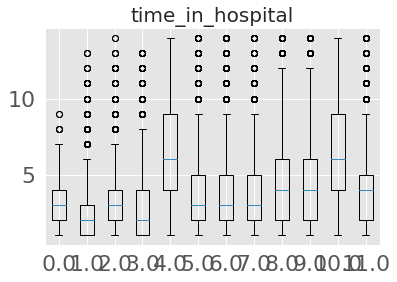

time_in_hospital CONTINUOUS [(4.0, 'CONTINUOUS', 1.3140335947530184), (8.0, 'CONTINUOUS', 0.5291792177387274), (9.0, 'CONTINUOUS', 0.5649905751353776), (10.0, 'CONTINUOUS', 1.358997829772421)] p-value= 0.0


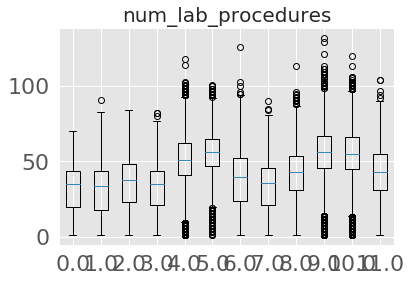

num_lab_procedures CONTINUOUS [(4.0, 'CONTINUOUS', 0.9508259153287646), (5.0, 'CONTINUOUS', 1.1732721899279808), (9.0, 'CONTINUOUS', 1.1913762322809438), (10.0, 'CONTINUOUS', 1.1426424749574886)] p-value= 0.0


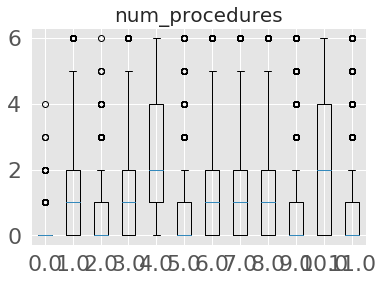

num_procedures CONTINUOUS [(1.0, 'CONTINUOUS', 0.5863563559742194), (4.0, 'CONTINUOUS', 1.3138423561036423), (8.0, 'CONTINUOUS', 0.5701174218823315), (10.0, 'CONTINUOUS', 1.1706908135326337)] p-value= 0.0


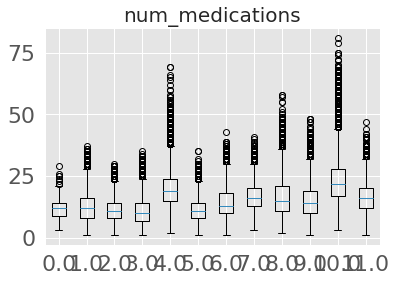

num_medications CONTINUOUS [(4.0, 'CONTINUOUS', 1.0169432639893095), (7.0, 'CONTINUOUS', 0.5661740023865982), (8.0, 'CONTINUOUS', 0.5814408416784658), (10.0, 'CONTINUOUS', 1.456776444882459), (11.0, 'CONTINUOUS', 0.5581424223170127)] p-value= 0.0


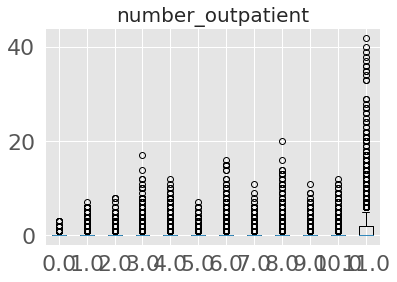

number_outpatient CONTINUOUS [(11.0, 'CONTINUOUS', 0.9303336509652183)] p-value= 0.0


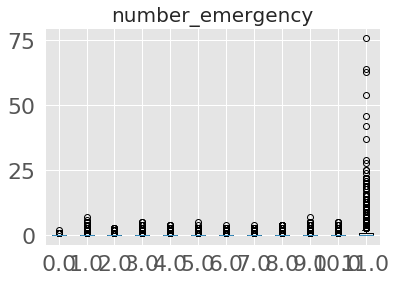

number_emergency CONTINUOUS [(11.0, 'CONTINUOUS', 1.0821879910949337)] p-value= 0.0


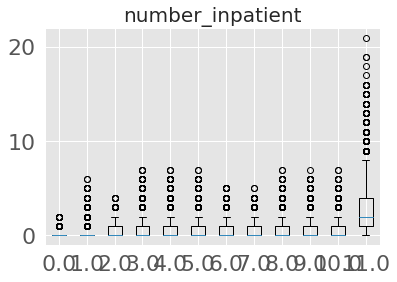

number_inpatient CONTINUOUS [(11.0, 'CONTINUOUS', 1.8722321803538933)] p-value= 0.0


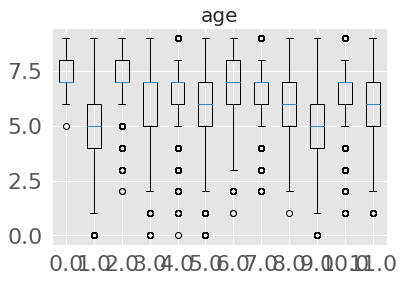

age ORDINAL [(0.0, 'CONTINUOUS', 0.8074708377102693)] p-value= 0.0


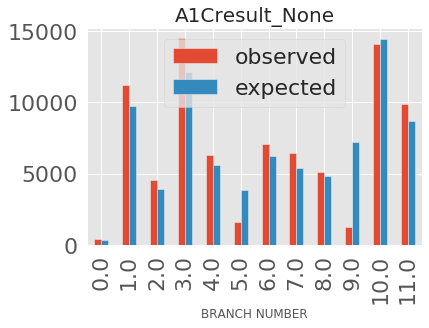

A1Cresult_None BINARY [(5.0, 0.0, 0.5916970996962457), (9.0, 0.0, 0.6684806503219783)] p-value= 0.0


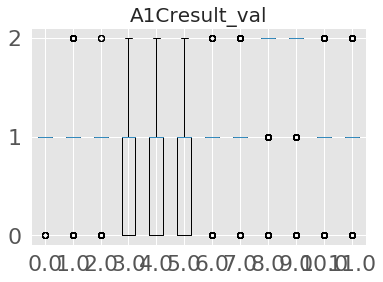

A1Cresult_val ORDINAL [(8.0, 'CONTINUOUS', 1.575042179142425), (9.0, 'CONTINUOUS', 1.3555763093133246)] p-value= 0.0


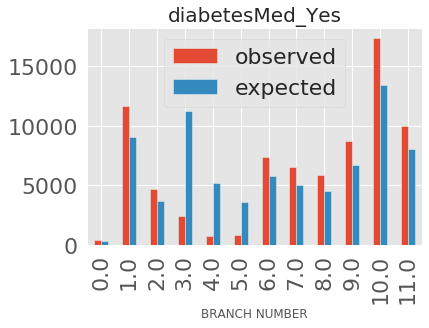

diabetesMed_Yes BINARY [(3.0, 0.0, 0.5712447544973417), (4.0, 0.0, 0.5923518871085293), (5.0, 0.0, 0.562900670535896)] p-value= 0.0


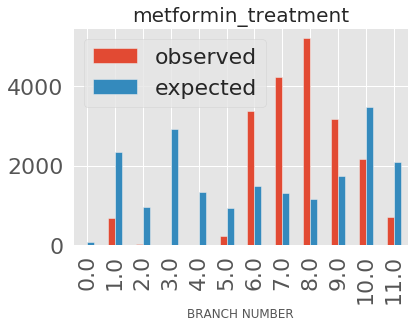

metformin_treatment BINARY [(7.0, 1.0, 0.5294207669732102), (8.0, 1.0, 0.6333951514786086)] p-value= 0.0


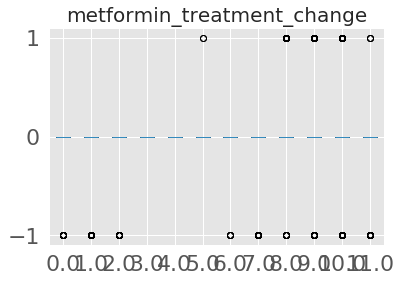

metformin_treatment_change ORDINAL [(8.0, 'CONTINUOUS', 1.282425539652123)] p-value= 0.0


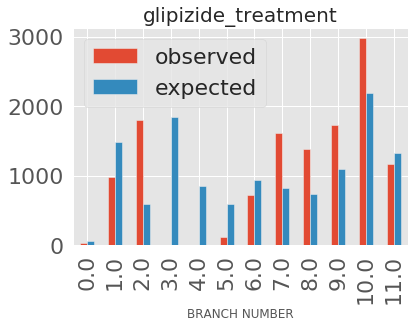

glipizide_treatment BINARY [(2.0, 1.0, 0.5006618582270377)] p-value= 0.0


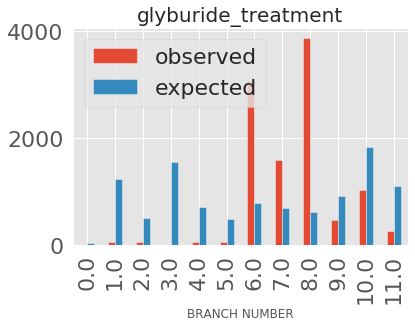

glyburide_treatment BINARY [(6.0, 1.0, 0.588670012961559), (8.0, 1.0, 0.7240418608020747)] p-value= 0.0


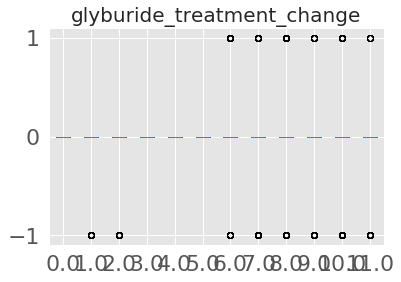

glyburide_treatment_change ORDINAL [(8.0, 'CONTINUOUS', 0.881692394047945)] p-value= 0.0


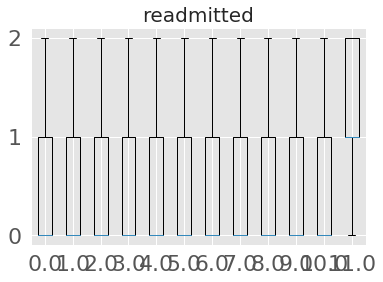

readmitted ORDINAL [(11.0, 'CONTINUOUS', 1.1902205500781835)] p-value= 0.0


In [311]:
# Associate branches (vec_labels_by_branches) and variables (chi-square : binary, ordinal and categorical
# and ANOVA for continuous)

reload(clintraj_util)
from clintraj_util import associate_with_categorical_var


Negative_Enrichment = False
Threshold_Deviation = 0.5
Threshold_Parameter = 0.5
Minimal_number_of_points = 10
pvalue_threshold_parameter = 0.01
produce_plots = True

all_branch_var_associations = {}

for k,var in enumerate(variable_names):
    var_type = variable_types[k]
    vals = X_original[:,k]
    list_of_branch_var_associations=[]
    if var_type=='BINARY' or var_type=='CATEGORICAL':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if var_type=='ORDINAL' or var_type=='CONTINUOUS':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Parameter,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if len(list_of_branch_var_associations)>0:
        print(var,var_type,list_of_branch_var_associations,'p-value=',p)
        all_branch_var_associations[var] = list_of_branch_var_associations

['A1Cresult_val', 'metformin_treatment', 'glyburide_treatment', 'metformin_treatment_change', 'glyburide_treatment_change', 'num_medications', 'time_in_hospital', 'num_procedures', 'diabetesMed_Yes', 'num_lab_procedures', 'A1Cresult_None', 'readmitted', 'number_inpatient', 'number_outpatient', 'number_emergency', 'age', 'glipizide_treatment']



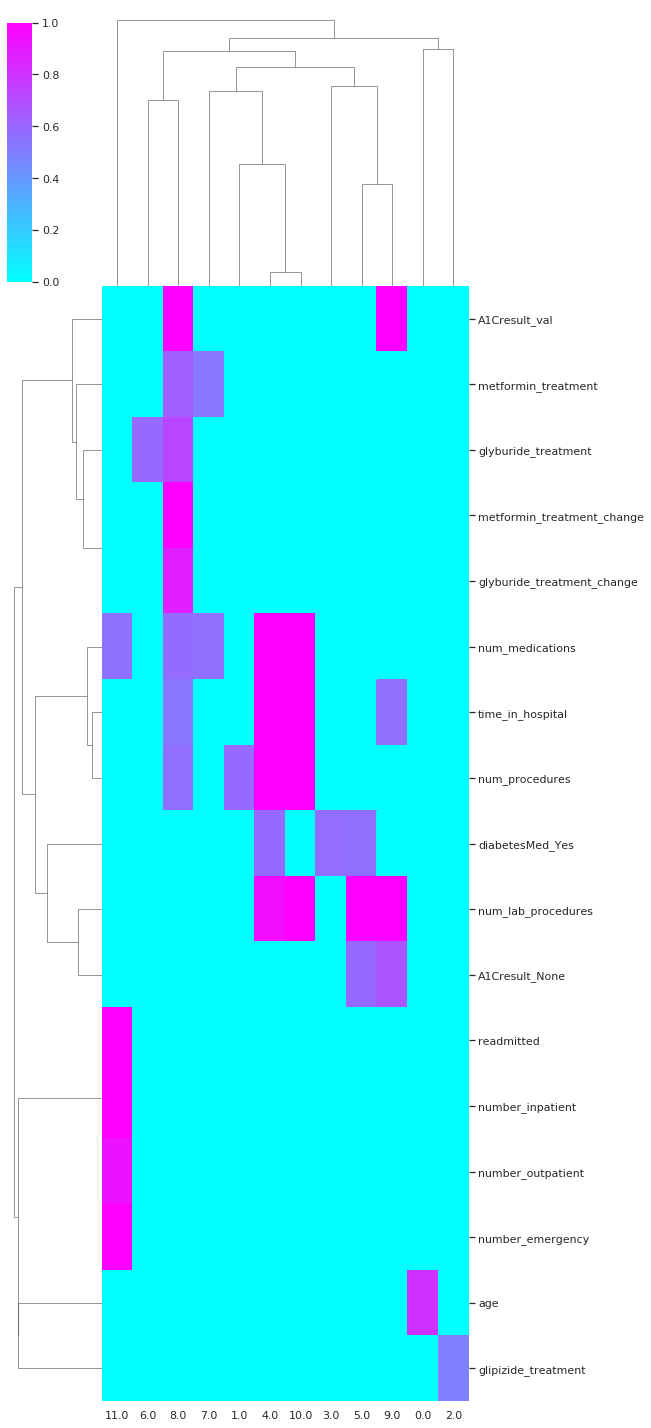

In [312]:
# Visualize associations between variables and tree branches

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_branch_var_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20),vmax=1,cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig(dataset_name+'_assoc_branches.png', format='png', dpi=300)
print()

In [89]:
reload(clintraj_eltree)
from clintraj_eltree import convert_elpigraph_to_igraph, extract_trajectories, quantify_pseudotime

# Quantify pseudo-time

partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))

all_trajectories,all_trajectories_edges = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct)
# add information about bifurcation points
g = convert_elpigraph_to_igraph(tree_extended)
degs = g.degree()
for pss in PseudoTimeTraj:
    traj = pss['Trajectory']
    branching_marks = []
    for i,n in enumerate(traj):
        if degs[n]>2 and i>0:
            branching_marks.append(i)
    pss['BranchingPoints'] = branching_marks
    #print(n,branching_marks)

8  trajectories found.


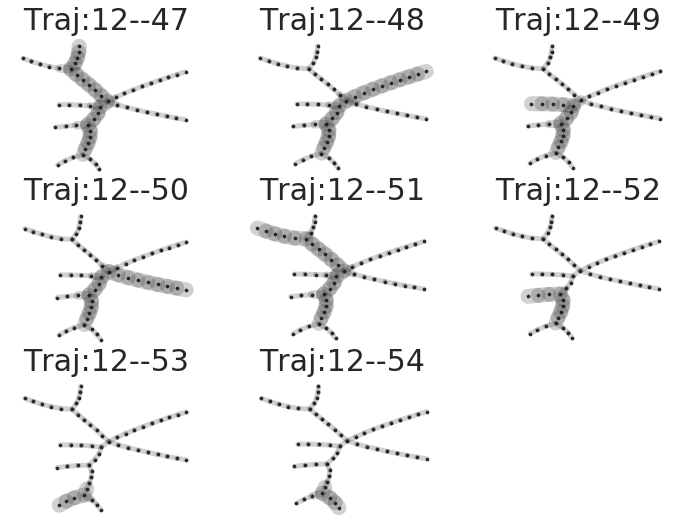

In [314]:
# Visualize all trajectories
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 12))

for i,pstt in enumerate(PseudoTimeTraj):
    points = list(pstt['Points'])
    X_fake = np.zeros((X.shape[0],1))
    X_fake[points,0] = 1.0
    TrajName = 'Traj:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i+1)
    plt.title(TrajName,fontsize=30)
    visualize_eltree_with_data(tree_extended,X,X_fake,v,mean_val,color,['Traj'],
                          Min_Edge_Width=5,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
    plt.axis('off')
    #plt.savefig(dataset_name+'_trajectories.png', format='png', dpi=300)



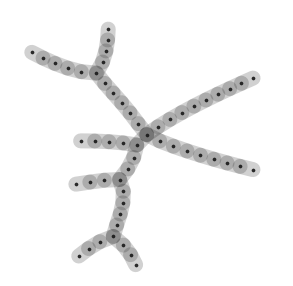

In [384]:
# produce principal tree scaffold image

fig = plt.figure(figsize=(5, 5))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,['Traj'],
                          Min_Edge_Width=15,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
plt.axis('off')
plt.savefig(dataset_name+'_tree_structure.png', format='png', dpi=600)


time_in_hospital CONTINUOUS


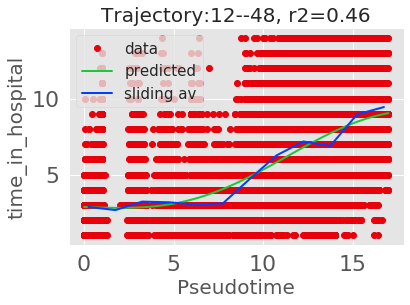

1 ('Trajectory:12--48', 'time_in_hospital', 0.4638496085963758)


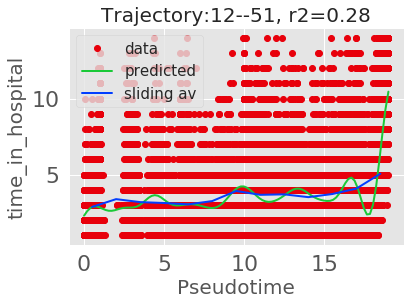

4 ('Trajectory:12--51', 'time_in_hospital', 0.27959580147204277)


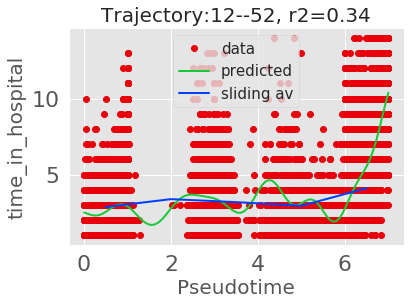

5 ('Trajectory:12--52', 'time_in_hospital', 0.34155394543664497)


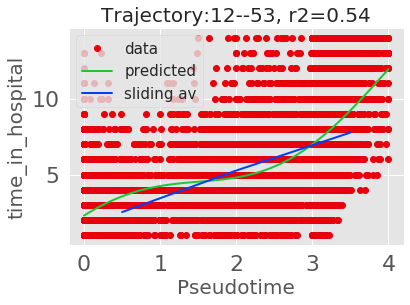

6 ('Trajectory:12--53', 'time_in_hospital', 0.5375275523756564)


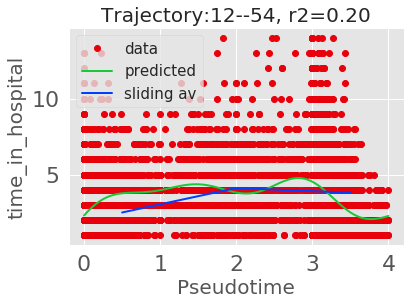

7 ('Trajectory:12--54', 'time_in_hospital', 0.20054529738446236)
[('Trajectory:12--48', 'time_in_hospital', 0.4638496085963758), ('Trajectory:12--51', 'time_in_hospital', 0.27959580147204277), ('Trajectory:12--52', 'time_in_hospital', 0.34155394543664497), ('Trajectory:12--53', 'time_in_hospital', 0.5375275523756564), ('Trajectory:12--54', 'time_in_hospital', 0.20054529738446236)]
num_lab_procedures CONTINUOUS


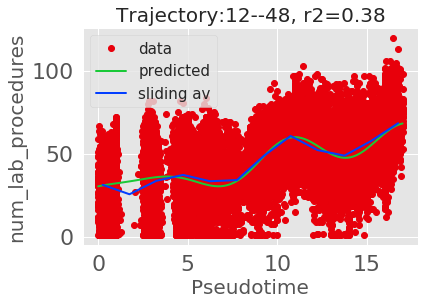

1 ('Trajectory:12--48', 'num_lab_procedures', 0.37622748653474425)


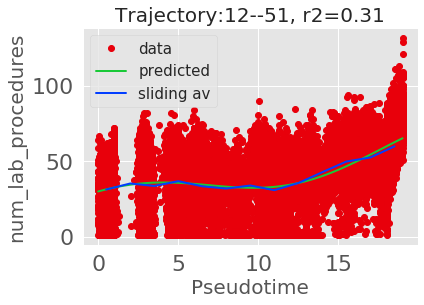

4 ('Trajectory:12--51', 'num_lab_procedures', 0.30681451719017505)


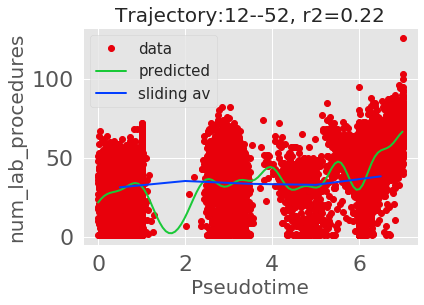

5 ('Trajectory:12--52', 'num_lab_procedures', 0.21868471174920623)


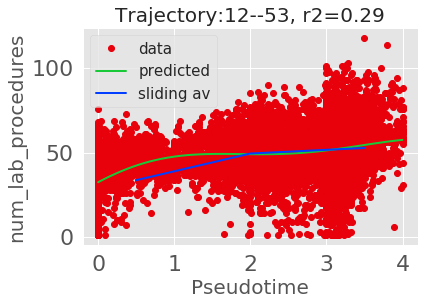

6 ('Trajectory:12--53', 'num_lab_procedures', 0.2894019398979575)


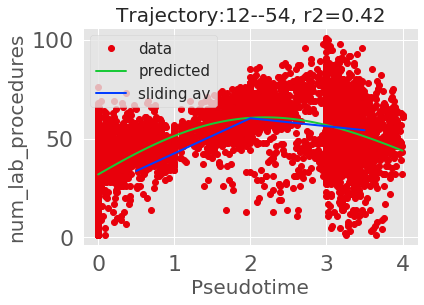

7 ('Trajectory:12--54', 'num_lab_procedures', 0.42352549221917557)
[('Trajectory:12--48', 'num_lab_procedures', 0.37622748653474425), ('Trajectory:12--51', 'num_lab_procedures', 0.30681451719017505), ('Trajectory:12--52', 'num_lab_procedures', 0.21868471174920623), ('Trajectory:12--53', 'num_lab_procedures', 0.2894019398979575), ('Trajectory:12--54', 'num_lab_procedures', 0.42352549221917557)]
num_procedures CONTINUOUS


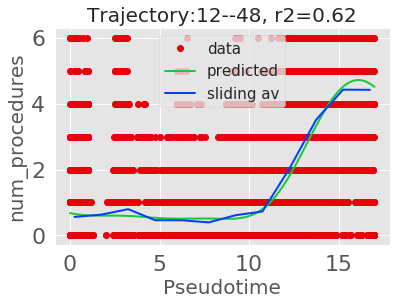

1 ('Trajectory:12--48', 'num_procedures', 0.6179021936743069)


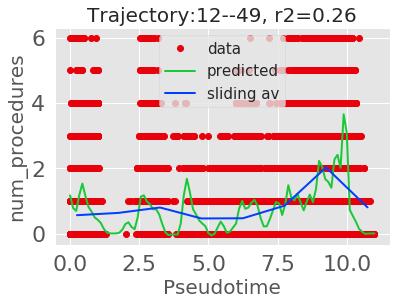

2 ('Trajectory:12--49', 'num_procedures', 0.2566027748492129)


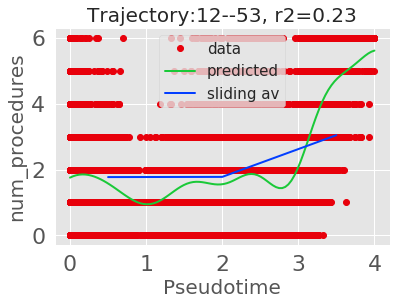

6 ('Trajectory:12--53', 'num_procedures', 0.2259781007480881)
[('Trajectory:12--48', 'num_procedures', 0.6179021936743069), ('Trajectory:12--49', 'num_procedures', 0.2566027748492129), ('Trajectory:12--53', 'num_procedures', 0.2259781007480881)]
num_medications CONTINUOUS


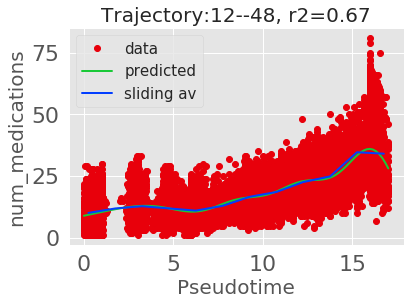

1 ('Trajectory:12--48', 'num_medications', 0.6658225726322835)


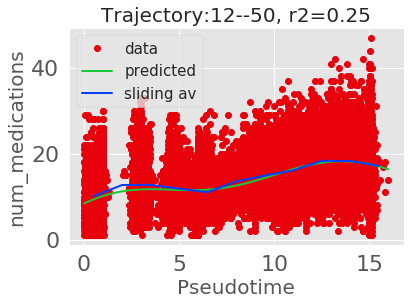

3 ('Trajectory:12--50', 'num_medications', 0.24668566588892604)


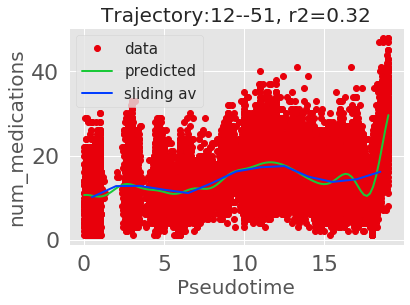

4 ('Trajectory:12--51', 'num_medications', 0.3203611906367124)


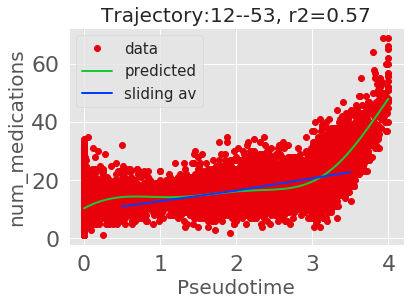

6 ('Trajectory:12--53', 'num_medications', 0.5739236817434966)
[('Trajectory:12--48', 'num_medications', 0.6658225726322835), ('Trajectory:12--50', 'num_medications', 0.24668566588892604), ('Trajectory:12--51', 'num_medications', 0.3203611906367124), ('Trajectory:12--53', 'num_medications', 0.5739236817434966)]
number_outpatient CONTINUOUS
number_emergency CONTINUOUS


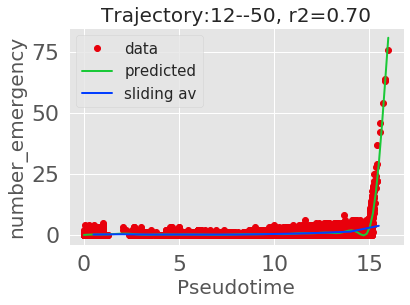

3 ('Trajectory:12--50', 'number_emergency', 0.7021187169122003)
[('Trajectory:12--50', 'number_emergency', 0.7021187169122003)]
number_inpatient CONTINUOUS


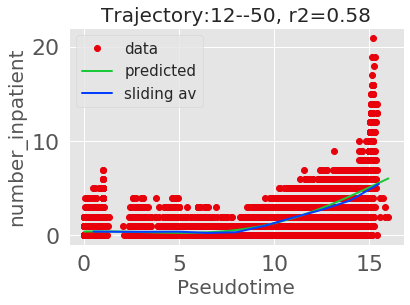

3 ('Trajectory:12--50', 'number_inpatient', 0.5804578090904382)
[('Trajectory:12--50', 'number_inpatient', 0.5804578090904382)]
number_diagnoses CONTINUOUS


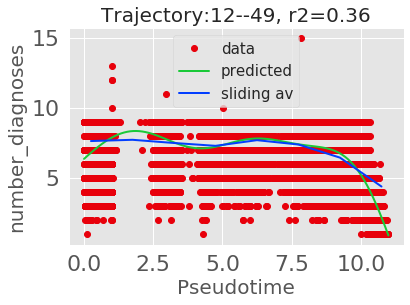

2 ('Trajectory:12--49', 'number_diagnoses', 0.36197400252182077)


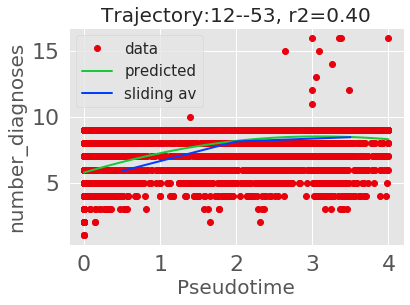

6 ('Trajectory:12--53', 'number_diagnoses', 0.40020757507907123)


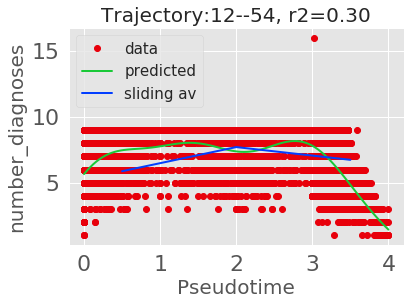

7 ('Trajectory:12--54', 'number_diagnoses', 0.3010715264419638)
[('Trajectory:12--49', 'number_diagnoses', 0.36197400252182077), ('Trajectory:12--53', 'number_diagnoses', 0.40020757507907123), ('Trajectory:12--54', 'number_diagnoses', 0.3010715264419638)]
age ORDINAL


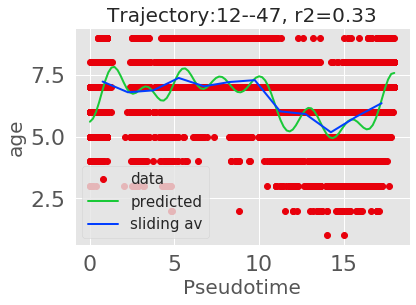

0 ('Trajectory:12--47', 'age', 0.3343278312926077)


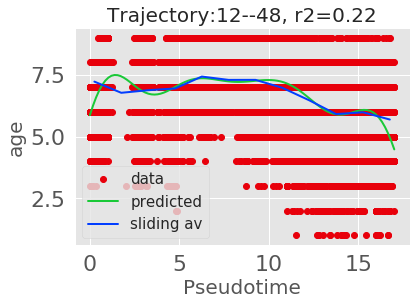

1 ('Trajectory:12--48', 'age', 0.22452578518329502)


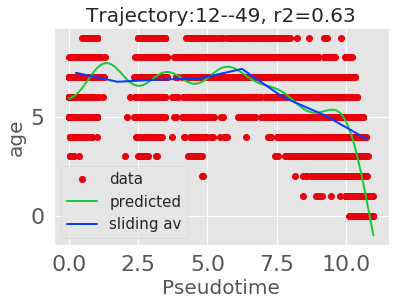

2 ('Trajectory:12--49', 'age', 0.6255230461799829)


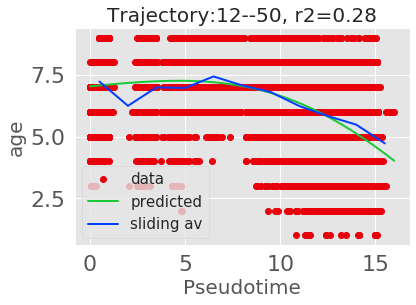

3 ('Trajectory:12--50', 'age', 0.27608774998089003)


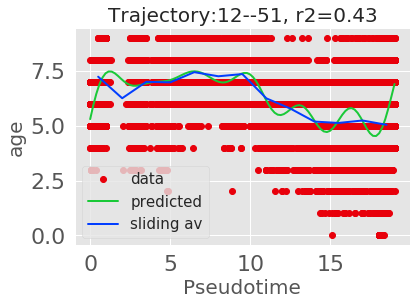

4 ('Trajectory:12--51', 'age', 0.4334121958181296)


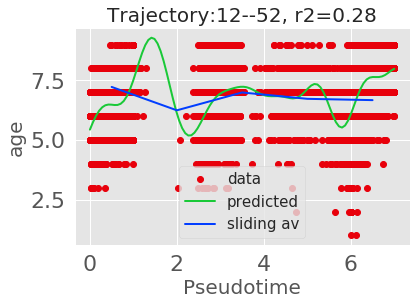

5 ('Trajectory:12--52', 'age', 0.2828107717046815)


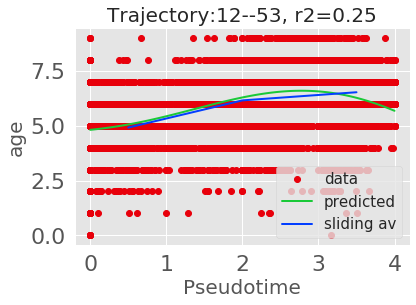

6 ('Trajectory:12--53', 'age', 0.249519877478099)


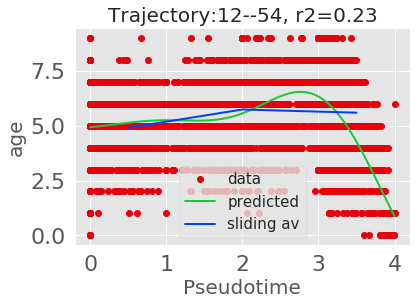

7 ('Trajectory:12--54', 'age', 0.2321209733940477)
[('Trajectory:12--47', 'age', 0.3343278312926077), ('Trajectory:12--48', 'age', 0.22452578518329502), ('Trajectory:12--49', 'age', 0.6255230461799829), ('Trajectory:12--50', 'age', 0.27608774998089003), ('Trajectory:12--51', 'age', 0.4334121958181296), ('Trajectory:12--52', 'age', 0.2828107717046815), ('Trajectory:12--53', 'age', 0.249519877478099), ('Trajectory:12--54', 'age', 0.2321209733940477)]
A1Cresult_None BINARY


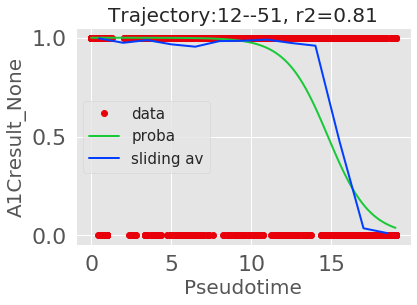

4 ('Trajectory:12--51', 'A1Cresult_None', 0.8078178081461451)


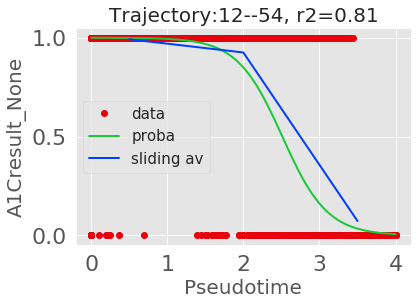

7 ('Trajectory:12--54', 'A1Cresult_None', 0.8125085350295582)
[('Trajectory:12--51', 'A1Cresult_None', 0.8078178081461451), ('Trajectory:12--54', 'A1Cresult_None', 0.8125085350295582)]
A1Cresult_val ORDINAL


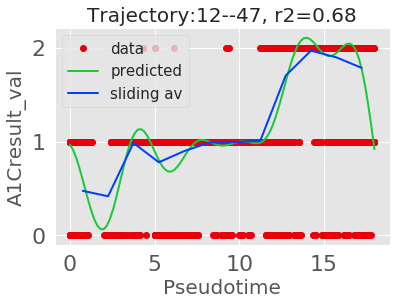

0 ('Trajectory:12--47', 'A1Cresult_val', 0.6835333292927959)


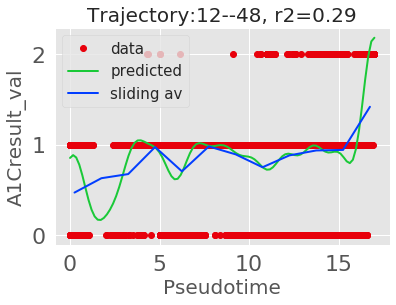

1 ('Trajectory:12--48', 'A1Cresult_val', 0.29318870171094613)


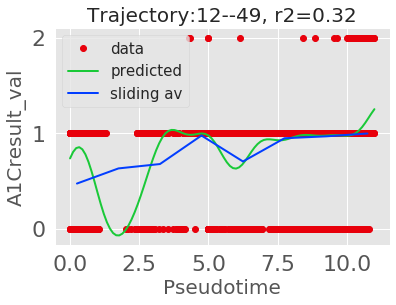

2 ('Trajectory:12--49', 'A1Cresult_val', 0.31782641565135894)


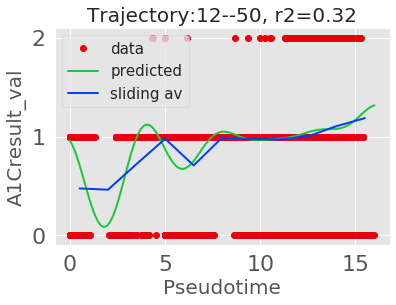

3 ('Trajectory:12--50', 'A1Cresult_val', 0.31565220051554577)


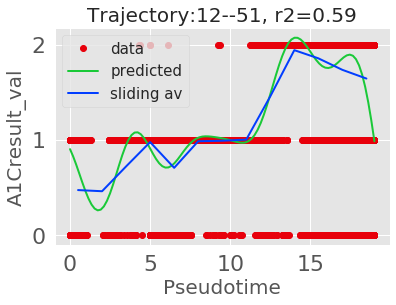

4 ('Trajectory:12--51', 'A1Cresult_val', 0.5892608050466153)


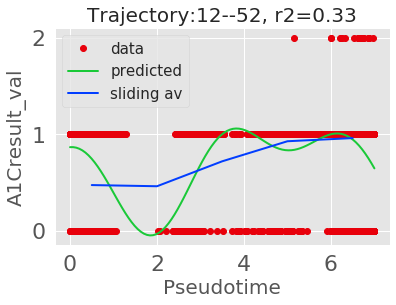

5 ('Trajectory:12--52', 'A1Cresult_val', 0.33442679086399285)


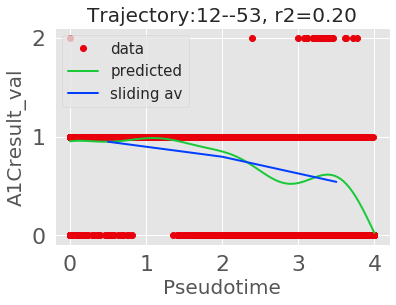

6 ('Trajectory:12--53', 'A1Cresult_val', 0.20379803588819279)


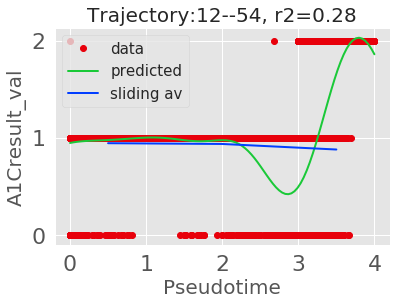

7 ('Trajectory:12--54', 'A1Cresult_val', 0.277598843291188)
[('Trajectory:12--47', 'A1Cresult_val', 0.6835333292927959), ('Trajectory:12--48', 'A1Cresult_val', 0.29318870171094613), ('Trajectory:12--49', 'A1Cresult_val', 0.31782641565135894), ('Trajectory:12--50', 'A1Cresult_val', 0.31565220051554577), ('Trajectory:12--51', 'A1Cresult_val', 0.5892608050466153), ('Trajectory:12--52', 'A1Cresult_val', 0.33442679086399285), ('Trajectory:12--53', 'A1Cresult_val', 0.20379803588819279), ('Trajectory:12--54', 'A1Cresult_val', 0.277598843291188)]
change_Ch BINARY


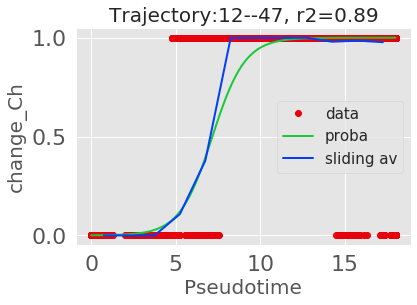

0 ('Trajectory:12--47', 'change_Ch', 0.8858517101165106)


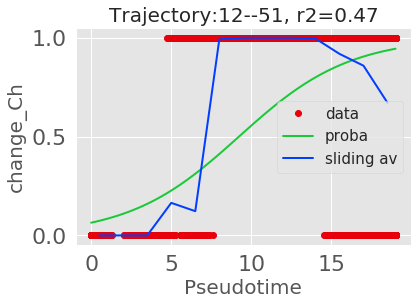

4 ('Trajectory:12--51', 'change_Ch', 0.4652315244798525)
[('Trajectory:12--47', 'change_Ch', 0.8858517101165106), ('Trajectory:12--51', 'change_Ch', 0.4652315244798525)]
diabetesMed_Yes BINARY


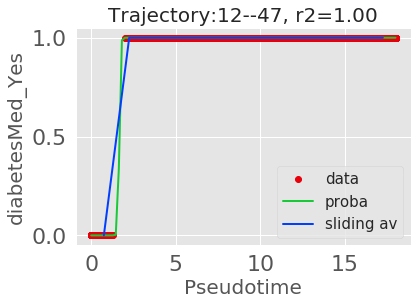

0 ('Trajectory:12--47', 'diabetesMed_Yes', 1.0)


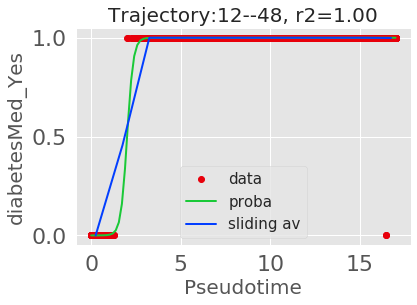

1 ('Trajectory:12--48', 'diabetesMed_Yes', 0.9996227552792402)


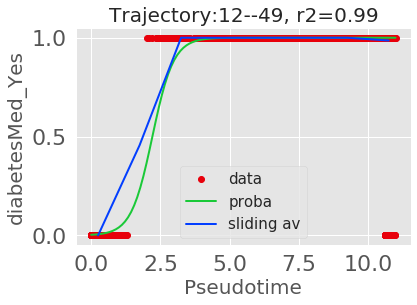

2 ('Trajectory:12--49', 'diabetesMed_Yes', 0.988136302380091)


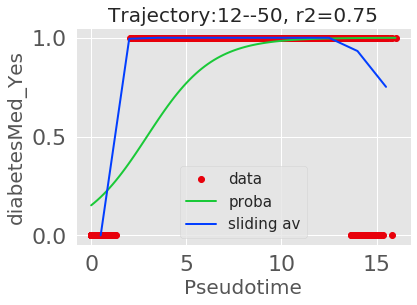

3 ('Trajectory:12--50', 'diabetesMed_Yes', 0.7451359090730201)


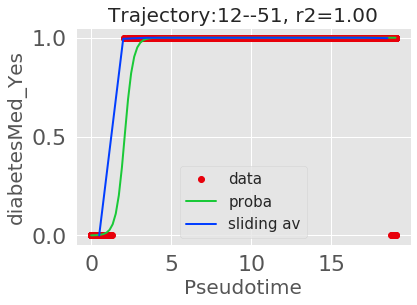

4 ('Trajectory:12--51', 'diabetesMed_Yes', 0.9976907453591646)


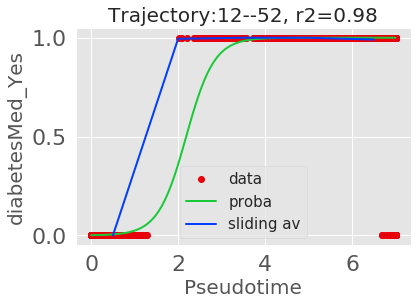

5 ('Trajectory:12--52', 'diabetesMed_Yes', 0.9839291987734642)
[('Trajectory:12--47', 'diabetesMed_Yes', 1.0), ('Trajectory:12--48', 'diabetesMed_Yes', 0.9996227552792402), ('Trajectory:12--49', 'diabetesMed_Yes', 0.988136302380091), ('Trajectory:12--50', 'diabetesMed_Yes', 0.7451359090730201), ('Trajectory:12--51', 'diabetesMed_Yes', 0.9976907453591646), ('Trajectory:12--52', 'diabetesMed_Yes', 0.9839291987734642)]
metformin_treatment BINARY


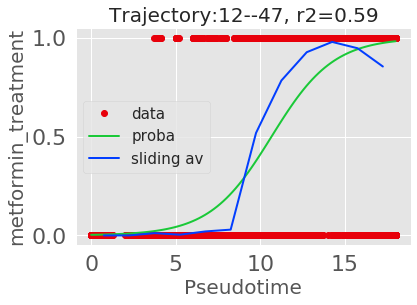

0 ('Trajectory:12--47', 'metformin_treatment', 0.5937779457270534)
[('Trajectory:12--47', 'metformin_treatment', 0.5937779457270534)]
metformin_treatment_change ORDINAL


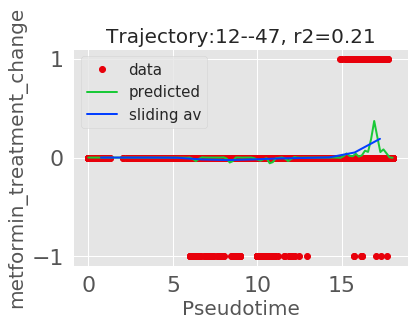

0 ('Trajectory:12--47', 'metformin_treatment_change', 0.2141915812862012)
[('Trajectory:12--47', 'metformin_treatment_change', 0.2141915812862012)]
glipizide_treatment BINARY
glipizide_treatment_change ORDINAL
glyburide_treatment BINARY
glyburide_treatment_change ORDINAL
insulin_treatment BINARY


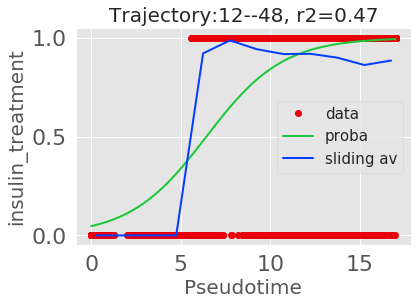

1 ('Trajectory:12--48', 'insulin_treatment', 0.4706061333462461)


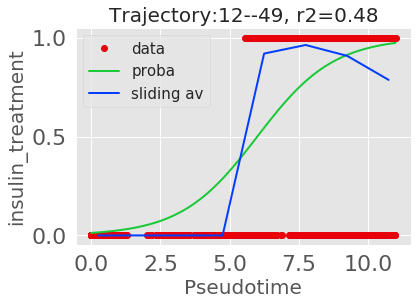

2 ('Trajectory:12--49', 'insulin_treatment', 0.4770065867445502)


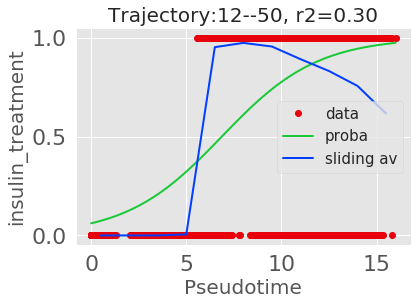

3 ('Trajectory:12--50', 'insulin_treatment', 0.2993593448678785)


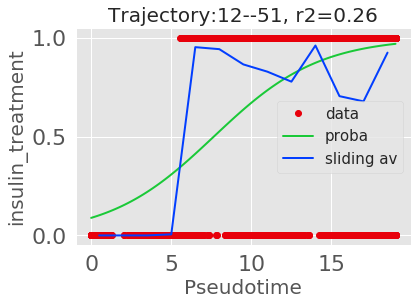

4 ('Trajectory:12--51', 'insulin_treatment', 0.2558687378578599)


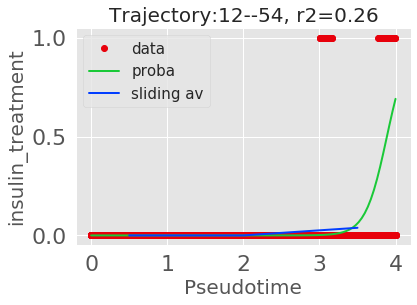

7 ('Trajectory:12--54', 'insulin_treatment', 0.257146700800163)
[('Trajectory:12--48', 'insulin_treatment', 0.4706061333462461), ('Trajectory:12--49', 'insulin_treatment', 0.4770065867445502), ('Trajectory:12--50', 'insulin_treatment', 0.2993593448678785), ('Trajectory:12--51', 'insulin_treatment', 0.2558687378578599), ('Trajectory:12--54', 'insulin_treatment', 0.257146700800163)]
insulin_treatment_change ORDINAL
readmitted ORDINAL


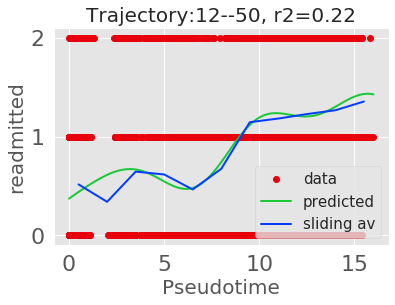

3 ('Trajectory:12--50', 'readmitted', 0.21947840801290208)
[('Trajectory:12--50', 'readmitted', 0.21947840801290208)]


In [25]:
# associate trajectories with variables by regression

reload(clintraj_eltree)
from clintraj_eltree import regression_of_variable_with_trajectories


R2_Threshold = 0.2
R2_Threshold_For_Readmission = 0.1
producePlot = True
all_trajectory_variable_associations = {}
readmission_variables = ['readmitted']

for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    if var in readmission_variables:
        r2th = R2_Threshold_For_Readmission
    else:
        r2th = R2_Threshold
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=r2th,
                                                                    producePlot=producePlot,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True,max_sample=2000,alpha_factor=1)
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations

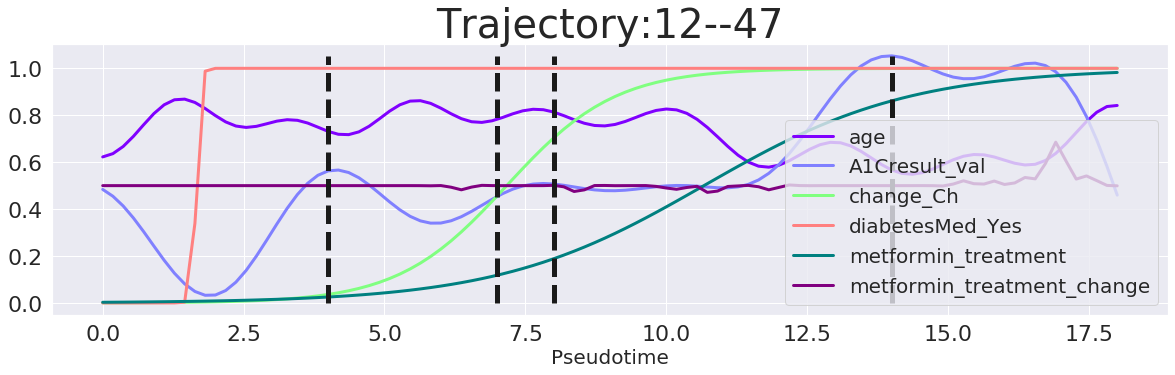

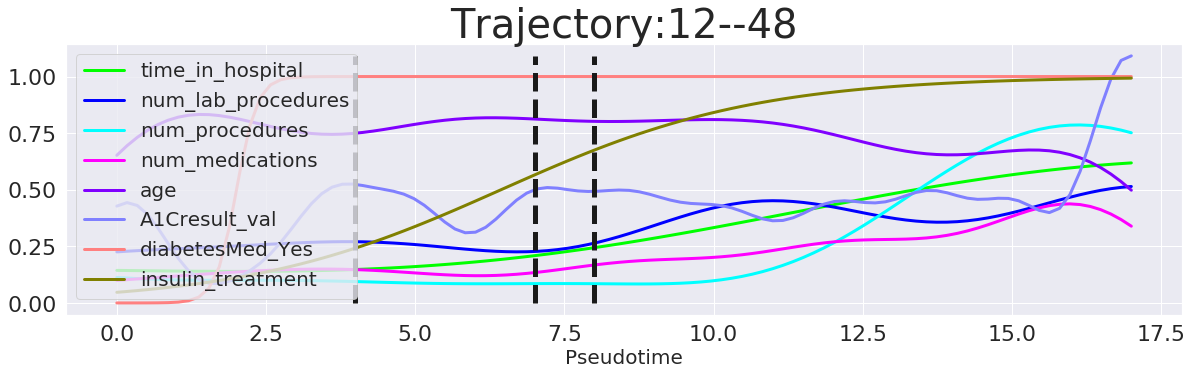

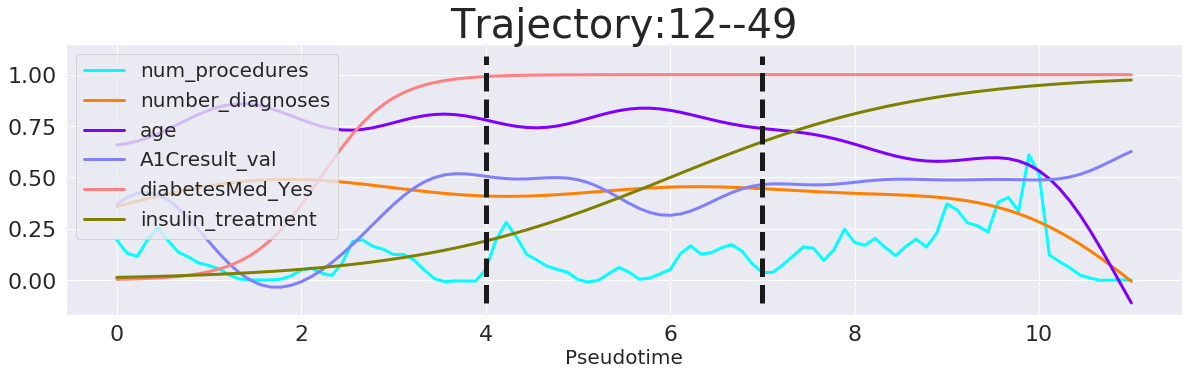

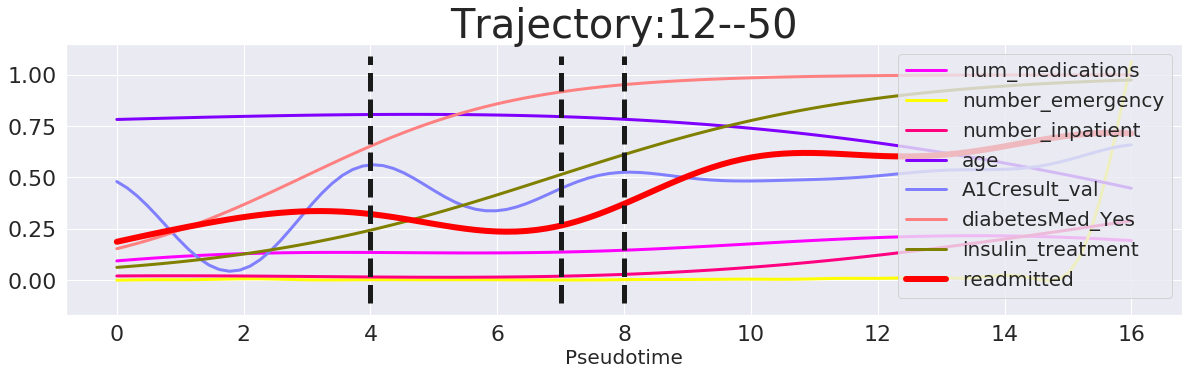

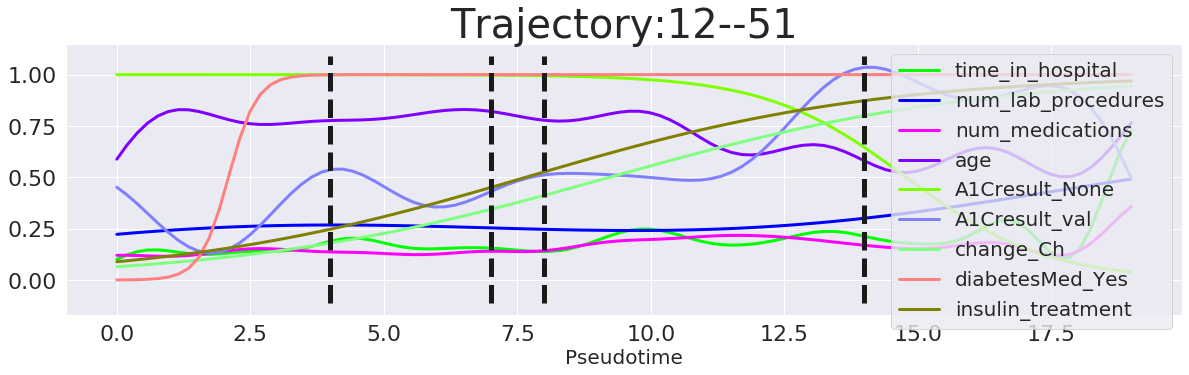

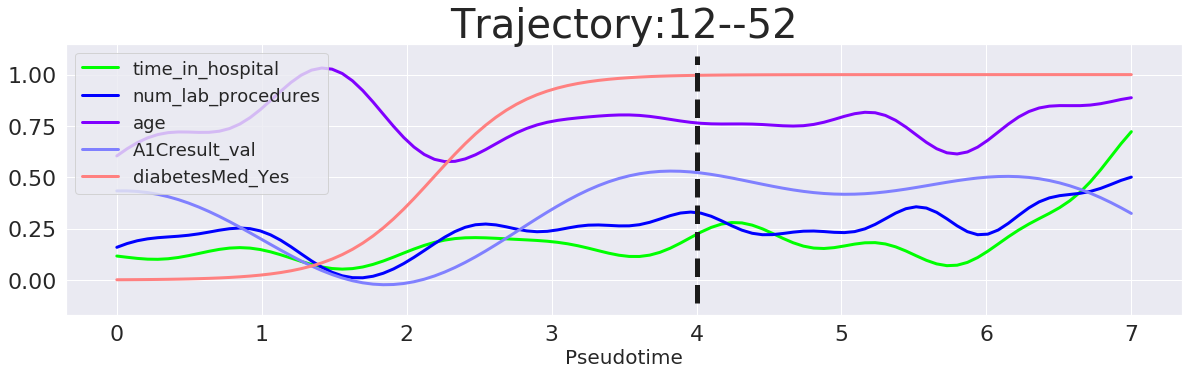

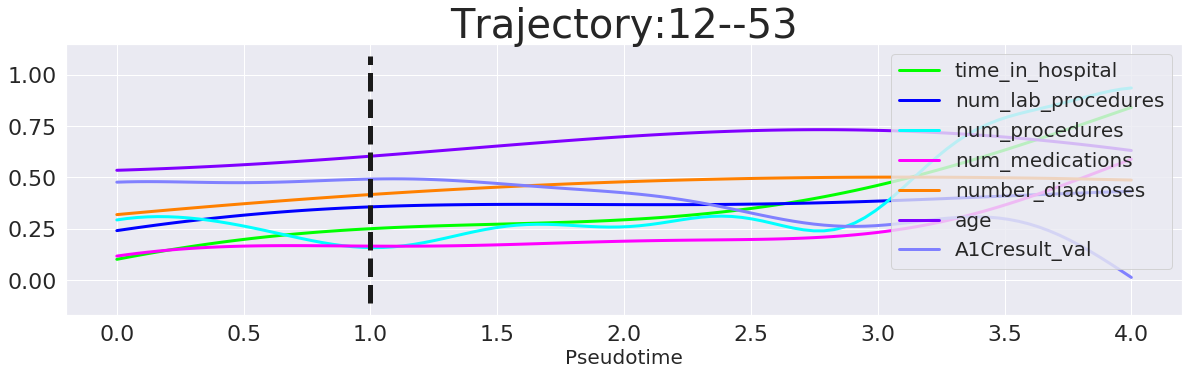

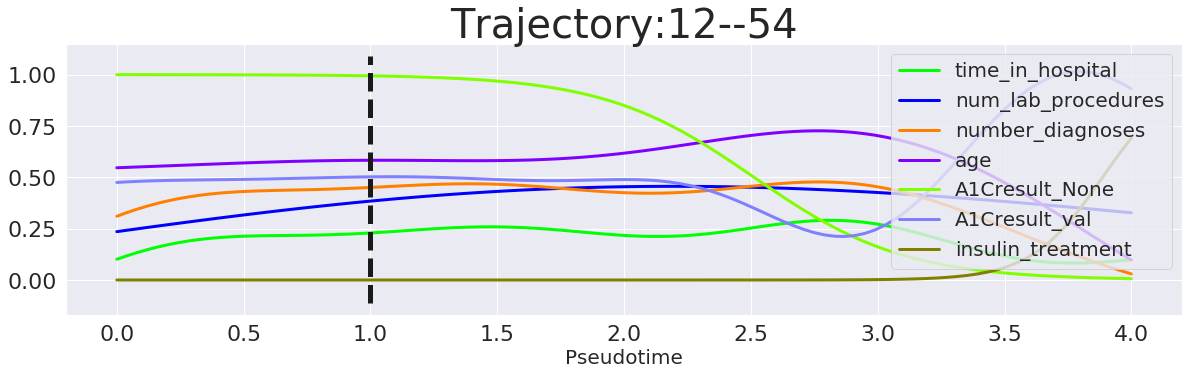

In [26]:
# Draw pseudotime dependencies of variables significantly associated with trajectories

reload(clintraj_util)
from clintraj_util import get_standard_color_seq


color_seq = get_standard_color_seq()
var_colors = {}
all_vars = list(all_trajectory_variable_associations.keys())
complication_variables = ['readmitted']
k=0
for var in complication_variables:
    if var in all_trajectory_variable_associations:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0
for var in all_vars:
    if not var in complication_variables:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0

sns.set(font_scale=2)

min_val = 1
max_val = 0

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    fig = plt.figure(figsize=(20, 5))
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn==TrajName:
                var = assoc[1]
                if var in complication_variables:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=6,draw_datapoints=False)
                else:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=3,draw_datapoints=False)
                if vals is not None:
                    min_val = min(min_val,min(vals))
                    max_val = max(max_val,max(vals))
                #else:
                #    print(var,TrajName,' regressor is not found')
    bp = pstt['BranchingPoints']
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    if TrajName.endswith('52'):
        plt.legend(fontsize=18,loc='upper left')
    else:
        plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=40)
    plt.savefig(dataset_name+'_'+TrajName+'.png', format='png', dpi=300)
    plt.show()

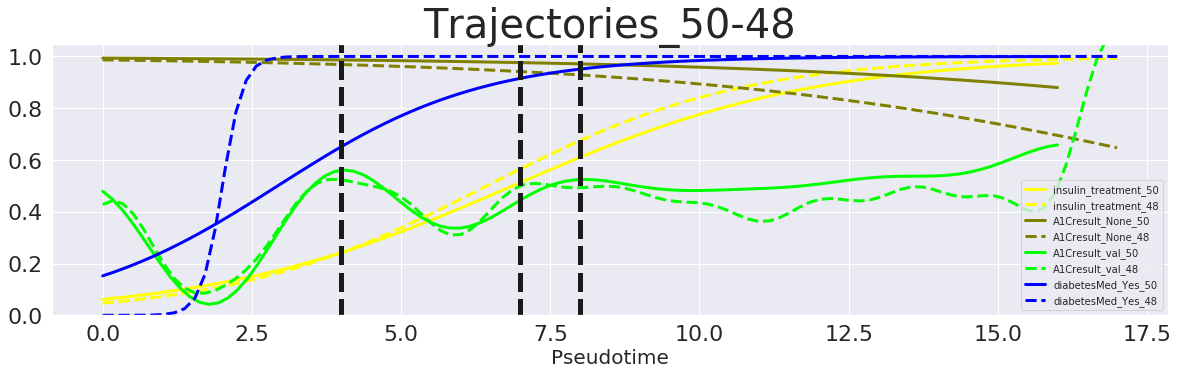

In [30]:
## Show selected variable dynamics on several trajectories simultaneously

reload(clintraj_eltree)
from clintraj_eltree import draw_pseudotime_dependence


color_seq = get_standard_color_seq()
var_colors = {}
line_styles = ['-','--','-.',':']

trajs_endpoints = [50,48]
trajs_endpoints_str = [str(ep) for ep in trajs_endpoints]
trajs = len(trajs_endpoints)*[None]
for pstt in PseudoTimeTraj:
    traj = pstt['Trajectory']
    if traj[-1] in trajs_endpoints:
        trajs[trajs_endpoints.index(traj[-1])] = pstt


#all_vars = ['number_emergency','time_in_hospital','A1Cresult_None','A1Cresult_val','diabetesMed_Yes','change_Ch','readmitted']
#all_vars = ['number_emergency','insulin_treatment','time_in_hospital','A1Cresult_None','A1Cresult_val','diabetesMed_Yes','change_Ch','readmitted']
#all_vars = ['number_emergency','number_inpatient','time_in_hospital','num_procedures','readmitted']
all_vars = ['insulin_treatment','A1Cresult_None','A1Cresult_val','diabetesMed_Yes']
if False:
    all_vars = []
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn[-2:] in trajs_endpoints_str:
                all_vars.append(var)
    all_vars = list(set(all_vars))

for k,var in enumerate(all_vars):
    var_colors[var] = color_seq[k]

#var_colors[all_vars[0]] = [0,0.5,1]
#var_colors[all_vars[1]] = [0,1,1]
#var_colors[all_vars[2]] = [1,0,1]
#var_colors[all_vars[3]] = [0,0.5,0.5]
#var_colors[all_vars[4]] = [1,0,0]

var_colors[all_vars[0]] = [1,1,0]
var_colors[all_vars[1]] = [0.5,0.5,0]
var_colors[all_vars[2]] = [0,1,0]
var_colors[all_vars[3]] = [0,0,1]
    
title = 'Trajectories_'+'-'.join(trajs_endpoints_str)
fig = plt.figure(figsize=(20, 5))
bp = []
for var in all_vars:
    for p,pstt in enumerate(trajs):
        if var in complication_variables:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=6,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
        else:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=3,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
            #plt.legend(fontsize=20)
            #plt.ylim([0,1])
        if vals is not None:
            min_val = min(min_val,min(vals))
            max_val = max(max_val,max(vals))
        bp1 = pstt['BranchingPoints']
        bp = bp+bp1
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    plt.legend(fontsize=10)
    plt.title(title,fontsize=40)
    plt.savefig(dataset_name+'_'+title+'.png', format='png', dpi=300)
    
    plt.ylim([0,1.05])
    #plt.ylim([0,0.78])
    plt.savefig(dataset_name+'_bifurcation_example.png', format='png', dpi=300)
plt.show()
    

['num_lab_procedures', 'A1Cresult_None', 'number_diagnoses', 'time_in_hospital', 'num_procedures', 'num_medications', 'readmitted', 'number_emergency', 'number_inpatient', 'A1Cresult_val', 'change_Ch', 'metformin_treatment', 'glyburide_treatment', 'insulin_treatment', 'age', 'diabetesMed_Yes']



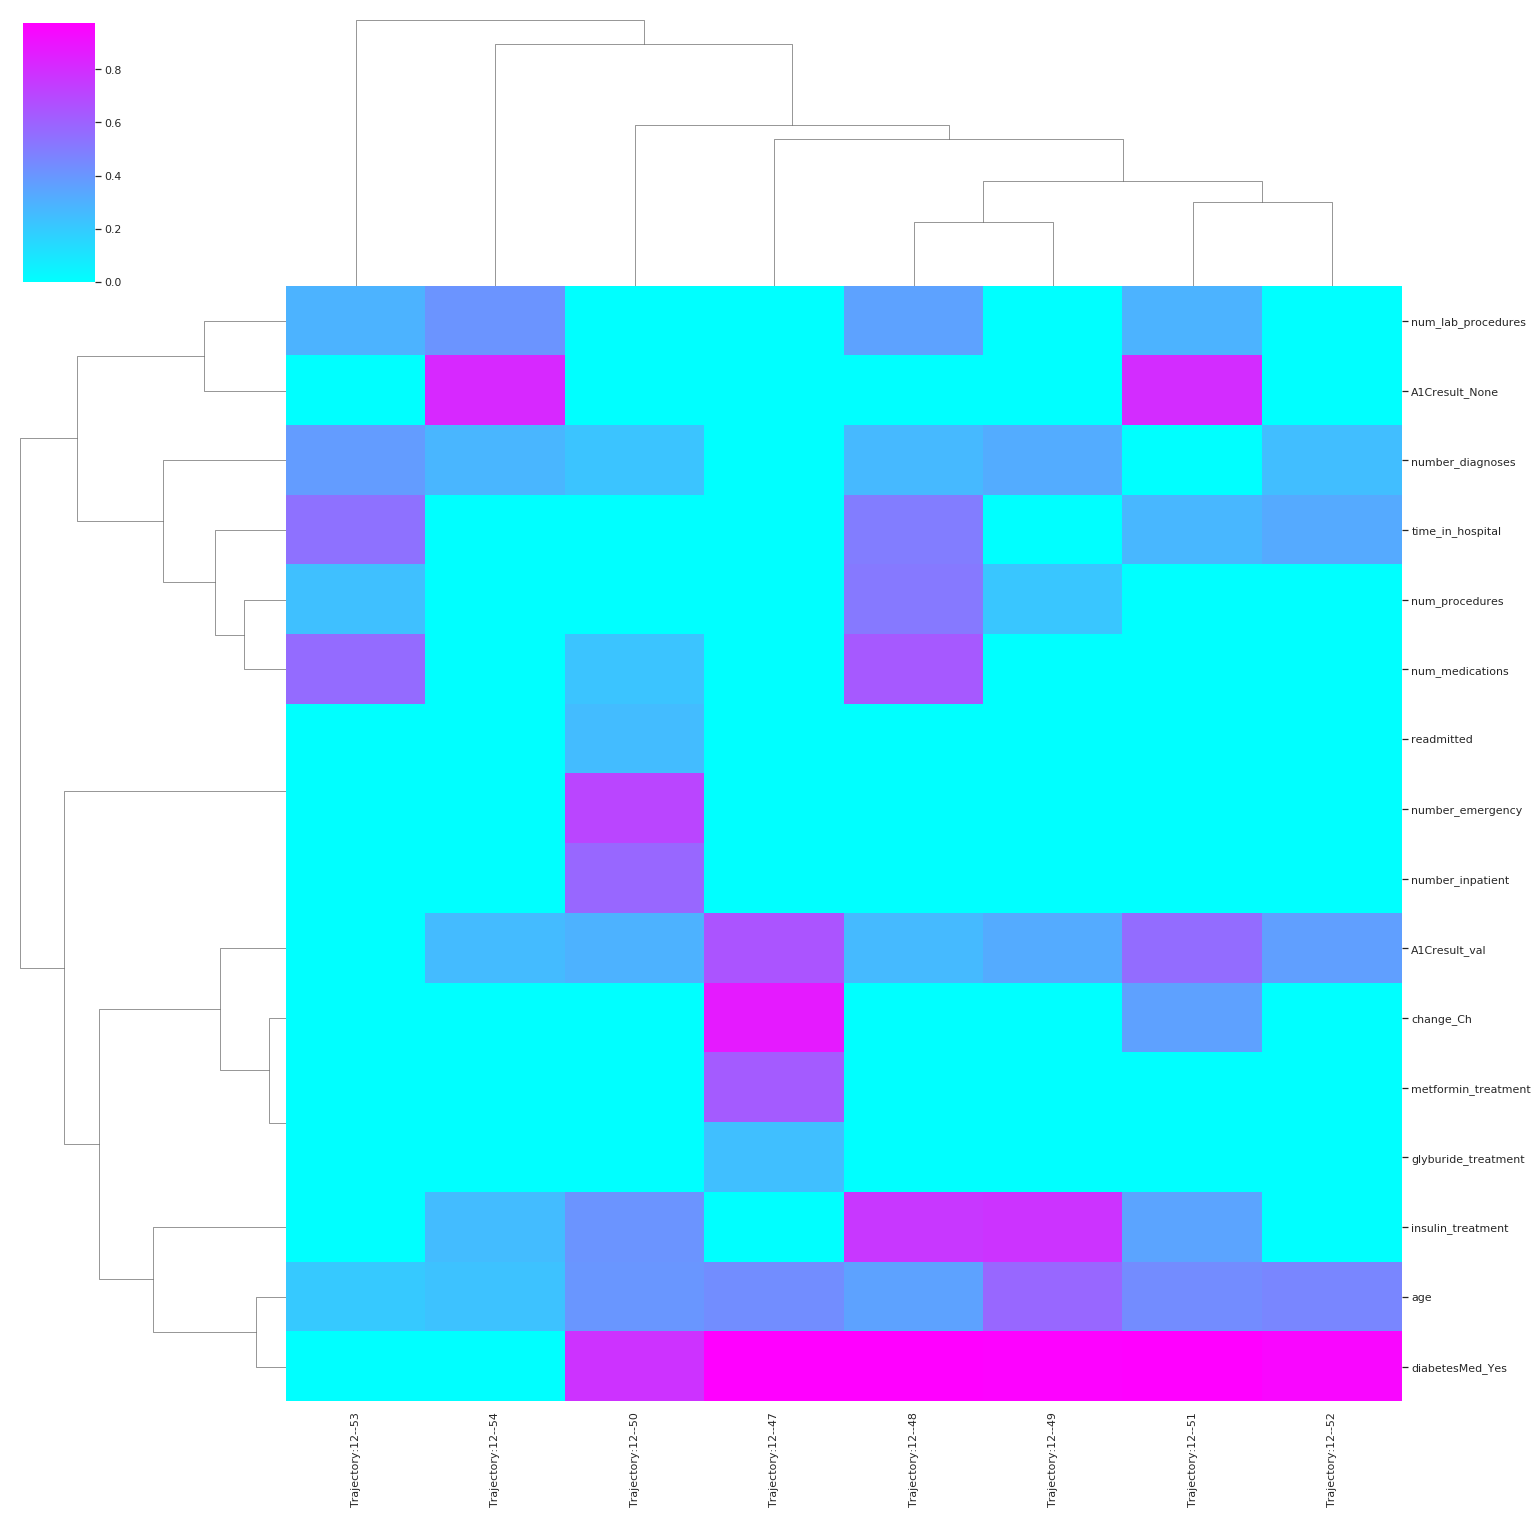

In [438]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(20, 20),cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig(dataset_name+'_associations_trajectories.png', format='png', dpi=300)
print()


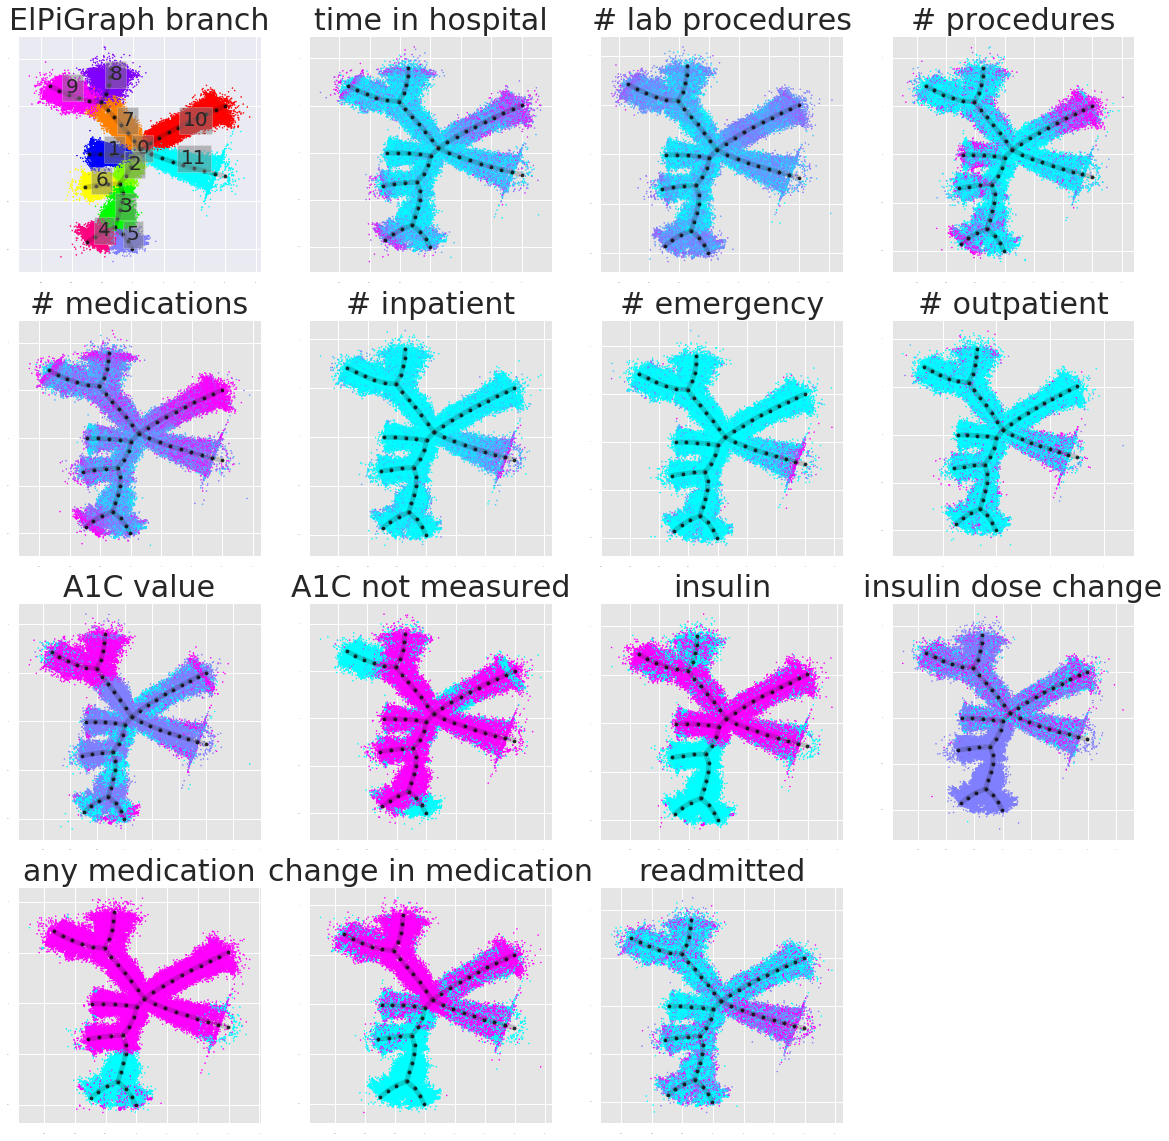

In [319]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

# visualizing some of the results on top of the tree

n_subplots_x, n_subplots_y = 4, 4
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))
title_font_size = 30
scatter_parameter = 0.1

cmap = 'cool'
point_size = 1
Max_Edge_Width = 5

showAll = True

sns.set(font_scale=0,palette='bright')

# Visualize partionining of data by branches
i=1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          showBranchNumbers=True,Color_by_partitioning=True,Normal_Point_Size=point_size,
                           visualize_partition=vec_labels_by_branches,scatter_parameter=scatter_parameter)
plt.title('ElPiGraph branch',fontsize=title_font_size)

# Show only points of classes strongly associated with branches
#i=i+1
#list_of_node_class_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,'CLASS',color,'CATEGORICAL',
#                                                            score_threshold=0.7,
#                                                            Negative_Enrichment=False,
#                                                            Minimal_number_of_points=5,verbose=False)
#ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
#plt.title('Classes associated\nwith branches',fontsize=title_font_size)
#visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
#                          Visualize_Branch_Class_Associations=list_of_node_class_associations,
#                          scatter_parameter=scatter_parameter)


# time_in_hospital
i=i+1
feature='time_in_hospital'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('time in hospital',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

#num_lab_procedures
if showAll:
    i=i+1
    feature='num_lab_procedures'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# lab procedures',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter)

#num_procedures
i=i+1
feature='num_procedures'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# procedures',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

#num_medications
if showAll:
    i=i+1
    feature='num_medications'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# medications',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter,vmax=30)


i=i+1
feature='number_inpatient'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# inpatient',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter,vmax=10)

i=i+1
feature='number_emergency'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# emergency',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter,vmax=5)


if showAll:
    i=i+1
    feature='number_outpatient'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# outpatient',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter,vmax=5)


#i=i+1
#feature='age'
#ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
#plt.title('age',fontsize=title_font_size)
#visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
#                          Invert_Edge_Value=True,Max_Edge_Width=20,Color_by_feature=feature, 
#                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
#                          scatter_parameter=scatter_parameter)

i=i+1
feature='A1Cresult_val'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('A1C value',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

if True:
    i=i+1
    feature='A1Cresult_None'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('A1C not measured',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter)


i=i+1
feature='insulin_treatment'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('insulin',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


i=i+1
feature='insulin_treatment_change'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('insulin dose change',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


i=i+1
feature='diabetesMed_Yes'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('any medication',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

i=i+1
feature='change_Ch'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('change in medication',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

i=i+1
feature='readmitted'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('readmitted',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


plt.savefig(dataset_name+'_principal_tree_visexamples.png', format='png', dpi=400)
plt.show()

[[0, 0, 1], [1, 1, 0], [0, 1, 0], [1, 0, 0]] [46379 30069 11908 10987]
['No', 'Steady', 'Down', 'Up'] [[0, 0, 1], [1, 1, 0], [0, 1, 0], [1, 0, 0]]
[[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]] [79499 18207  1063   574]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
[[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]] [86812 11219   764   548]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
[[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]] [88820  9162   801   560]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]


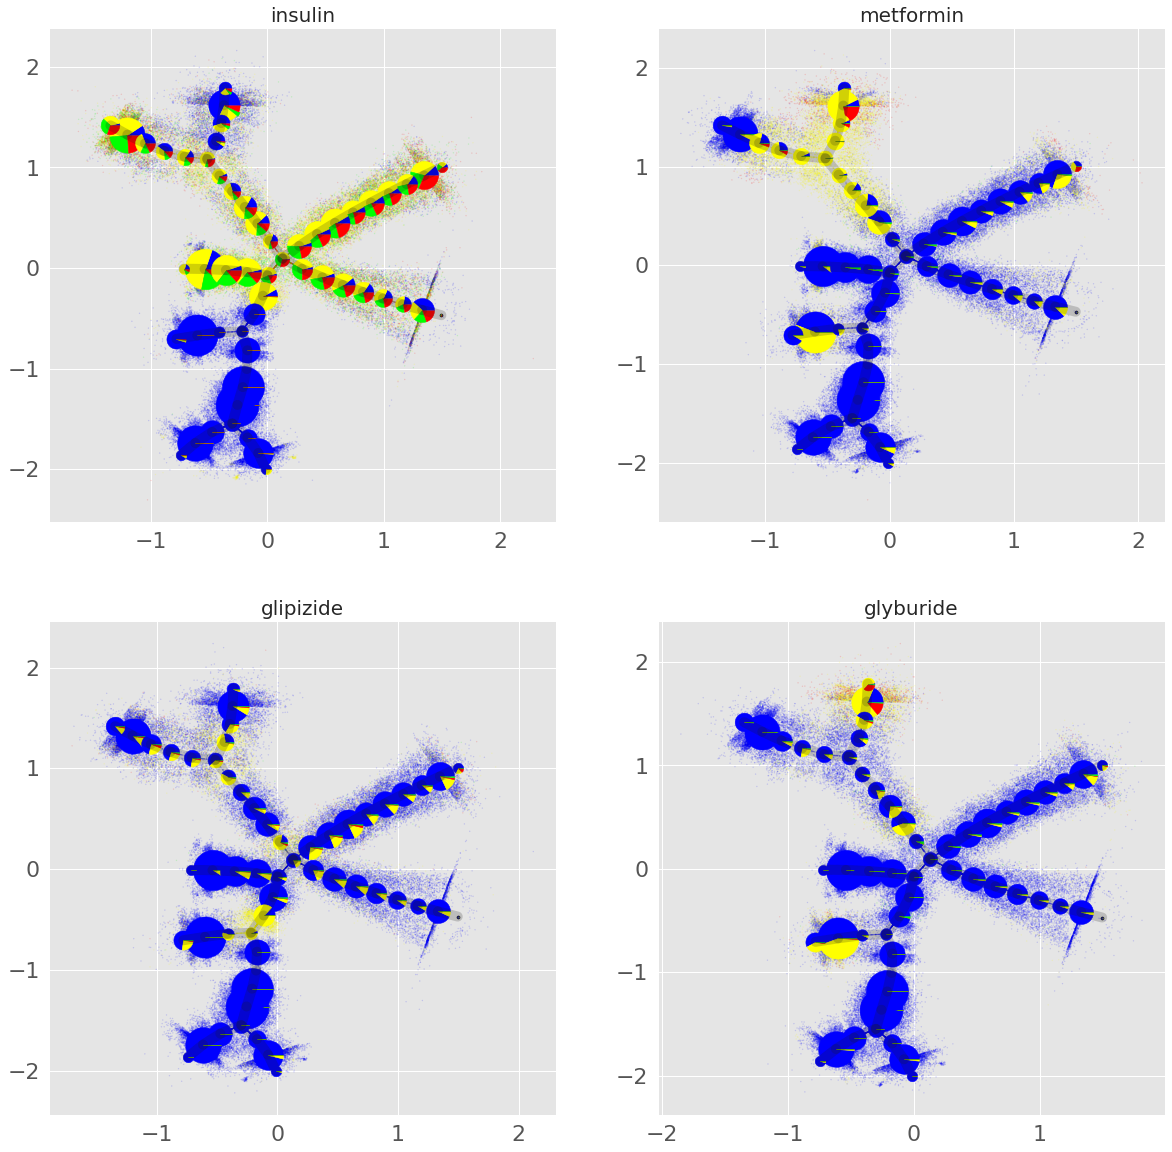

In [100]:
## visualize medication

reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime,add_pie_charts
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

title_font_size=20
point_size=1

medications = ['insulin','metformin','glipizide','glyburide']

fig = plt.figure(figsize=(20,20))
for i,feature in enumerate(medications):
    ax = fig.add_subplot(2,2,i+1)
    plt.title(feature,fontsize=title_font_size)
    color_seq = [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
    color_annot, vals_unique, vals_freq = get_colorseq_for_column(annotation_data,feature,color_seq)
    color_seq[vals_unique.index('No')] = [0,0,1]
    color_seq[vals_unique.index('Steady')] = [1,1,0]
    color_seq[vals_unique.index('Up')] = [1,0,0]
    color_seq[vals_unique.index('Down')] = [0,1,0]
    color_annot, vals_unique, vals_freq = get_colorseq_for_column(annotation_data,feature,color_seq)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                              Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                               Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                              Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                              Transparency_Alpha_points=0.1)
    add_pie_charts(ax,tree_extended['NodePositions2D'],color_annot,color_seq,partition,scale=0.3)
    print(vals_unique,color_seq)

plt.savefig(dataset_name+'_principal_tree_medications.png', format='png', dpi=400)
plt.show()


In [86]:
## visualize diagnosis

reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

title_font_size=20
point_size =2
feature = 'diag_1'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.title(feature,fontsize=title_font_size)
if feature=='diag_1':
    color_seq = [[1, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 0, 1]]
if feature=='diag_2':
    color_seq = [[1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
if feature=='diag_3':
    color_seq = [[1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]

color_annot, vals_unique, vals_unique_freq = get_colorseq_for_column(annotation_data,feature,color_seq=color_seq)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                          Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                           Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                          Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                          Transparency_Alpha_points=0.2)

print(vals_unique,vals_unique_freq,color_seq)

#plt.scatter(tree_extended['NodePositions2D'][:,0],tree_extended['NodePositions2D'][:,1],s=400)

vals = list(annotation_data[feature].replace({'Respiratory':'blue','Digestive':'blue','Injury':'blue'}))
add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['w','b','g','r'],scale=0.3,partition=partition)

plt.savefig(dataset_name+'_principal_tree_'+feature+'.png', format='png', dpi=400)
plt.show()

NameError: name 'partition' is not defined

['Emergency', 'Elective', 'Urgent', 'Other', 'Trauma Center', '4'] [52371 18668 18132 10144    18    10] [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1]]
['red', 'green', 'blue', 'white'] [52371 18668 18132 10172]


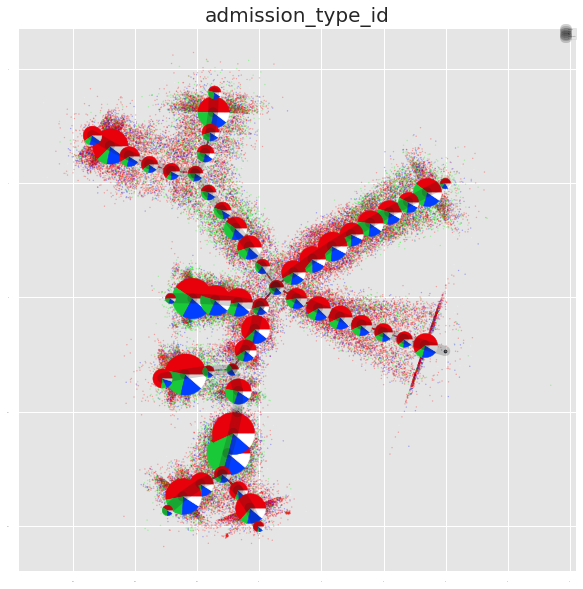

In [301]:

point_size =1

feature = 'admission_type_id'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.title(feature,fontsize=title_font_size)
color_seq = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 1],[0,0,1]]

color_annot, vals_unique, vals_unique_freq = get_colorseq_for_column(annotation_data,feature,color_seq=color_seq)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                          Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                           Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                          Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                          Transparency_Alpha_points=0.2)
print(vals_unique,vals_unique_freq,color_seq)
vals = list(annotation_data[feature].replace({'Emergency':'red','Elective':'green','Other':'white','Urgent':'blue','Trauma Center':'white','4':'white'}))
add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['r','g','b','w'],scale=0.3)
plt.legend(vals_unique)
plt.savefig(dataset_name+'_principal_tree_'+feature+'.png', format='png', dpi=400)
plt.show()


6
Start computations...
PCA: 1.9e-06 sec
t-SNE: 3.3e-06 sec
UMAP: 2.4e-06 sec
TRIMAP: 2.4e-06 sec


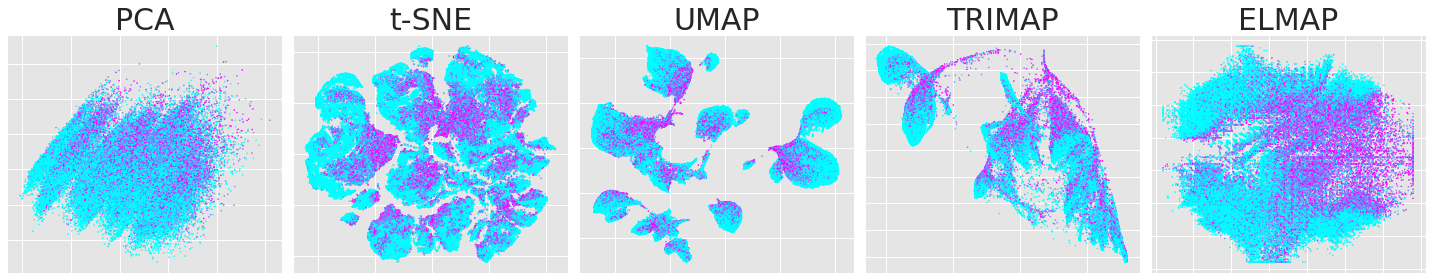

In [137]:
# Here the manifold learning is computed and saved in viz_results

print(X.shape[1])

sns.set(palette='bright')

methods_to_apply=['PCA','TRIMAP','UMAP','TSNE','ELMAP']
n_subplots_x=1
n_subplots_y=5
figsizex = 20
figsizey = 4

viz_results = apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=[],precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,points_size=1,
                                                      n_subplots_x=n_subplots_x,n_subplots_y=n_subplots_y,
                                                      figsizex=figsizex,figsizey=figsizey)
plt.savefig(dataset_name+'_manifolds_color_by_class.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 0.00031 sec
t-SNE: 0.0001 sec
UMAP: 0.00011 sec
TRIMAP: 0.00024 sec


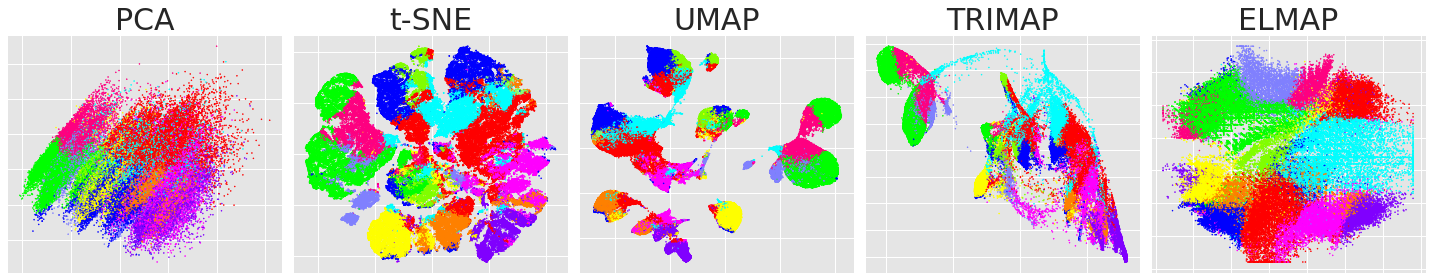

In [135]:
# Now we color by branches of the principal tree
# Here we use the results of the previous computations by specifying 'precomputed_results'

apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',ColorByFeature='', 
    variable_names=[],
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,n_subplots_x=n_subplots_x,n_subplots_y=n_subplots_y,
                                         figsizex=figsizex,figsizey=figsizey,points_size=1)
plt.savefig(dataset_name+'_manifolds_color_by_tree_branch.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 1.7e-06 sec
t-SNE: 1.9e-06 sec
UMAP: 3.8e-06 sec
TRIMAP: 2.1e-06 sec


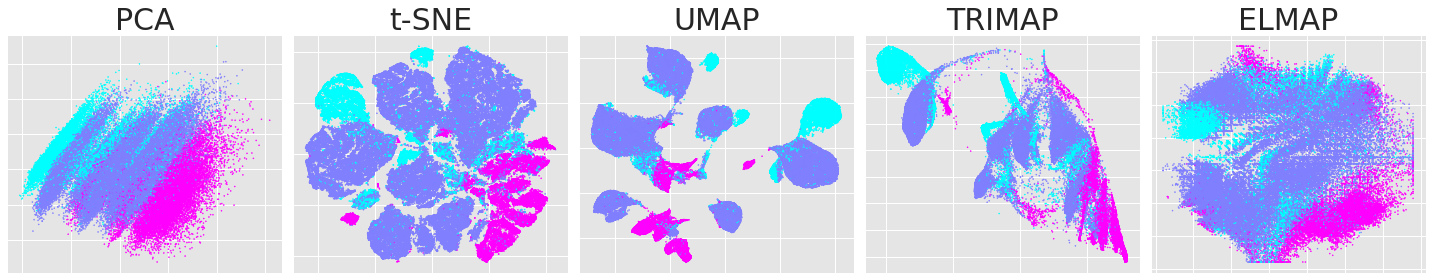

In [136]:
# Now we color by some features of the data
# Here we use the results of the previous computations by specifying 'precomputed_results'

#feature = 'number_inpatient'
#feature = 'time_in_hospital'
feature = 'A1Cresult_val'
#feature = 'A1Cresult_None'
#feature = 'readmitted'
#feature = 'number_outpatient'
#feature = 'age'
#feature = 'insulin_treatment'
#feature = 'insulin_treatment_change'
#feature = 'diabetesMed_Yes'
#feature = 'change_Ch'
#feature = 'metformin_treatment'
#feature = 'number_diagnoses'
#feature = 'number_emergency'
#feature = 'number_emergency'
#feature = 'readmitted'

apply_panel_of_manifold_learning_methods(X_original,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',
    ColorByFeature=feature, variable_names=variable_names,
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,
    n_subplots_x=1,n_subplots_y=5,
    figsizex=figsizex,figsizey=figsizey,points_size=1)
plt.savefig(dataset_name+'_manifolds_color_by_'+feature+'.png', format='png', dpi=300)
plt.show()

GROUP= Diabetis
size of the group= 8661


Trajectory= trajectory:12--48
size of the group= 1850
Fraction of readmitted= 0.11297297297297297
A1CValue predicted 0 = 0.07123287671232877 , n= 365
A1CValue predicted 1 = 0.12127814088598403 , n= 1377
A1CValue predicted 2 = 0.14814814814814814 , n= 108
A1CValue None = 0.10891089108910891  n = 1515
A1CValue= 0 : 0.1527777777777778  n = 144
A1CValue= 1 : 0.10526315789473684  n = 95
A1CValue= 2 : 0.125  n = 96
Testing multivalued A1CVal
p-value of chi2 test= 0.4366421532384167 stat= 2.7211670468280285


READMITTED          False  True 
A1CVal_categorical              
-1.0                 1350    165
 0.0                  122     22
 1.0                   85     10
 2.0                   84     12

READMITTED             False     True 
A1CVal_categorical                    
-1.0                0.002284 -0.018307
 0.0               -0.022952  0.149782
 1.0                0.004327 -0.035328
 2.0               -0.006826  0.050539

Testing A1CVal_None (not measured=0,measured=1)
p-value of chi2 test= 0.2808757609807053 stat= 1.1628475720329392


READMITTED          False  True 
A1CVal_categorical              
0                    1350    165
1                     291     44

READMITTED             False     True 
A1CVal_categorical                    
0                   0.002284 -0.018307
1                  -0.010463  0.075191



Trajectory= trajectory:12--50
size of the group= 1954
Fraction of readmitted= 0.27021494370522003
A1CValue predicted 0 = 0.06909090909090909 , n= 275
A1CValue predicted 1 = 0.2790224032586558 , n= 1473
A1CValue predicted 2 = 0.47572815533980584 , n= 206
A1CValue None = 0.26852367688022283  n = 1795
A1CValue= 0 : 0.2  n = 55
A1CValue= 1 : 0.25  n = 20
A1CValue= 2 : 0.35714285714285715  n = 84
Testing multivalued A1CVal
p-value of chi2 test= 0.19834406367279794 stat= 4.661324329200681


READMITTED          False  True 
A1CVal_categorical              
-1.0                 1313    482
 0.0                   44     11
 1.0                   15      5
 2.0                   54     30

READMITTED             False     True 
A1CVal_categorical                    
-1.0                0.001157 -0.003139
 0.0                0.045899 -0.149325
 1.0                0.013661 -0.038859
 2.0               -0.063329  0.138562

Testing A1CVal_None (not measured=0,measured=1)
p-value of chi2 test= 0.6365725713306427 stat= 0.2232527677664705


READMITTED          False  True 
A1CVal_categorical              
0                    1313    482
1                     113     46

READMITTED             False     True 
A1CVal_categorical                    
0                   0.001157 -0.003139
1                  -0.013255  0.034124



Trajectory= trajectory:12--51
size of the group= 2866
Fraction of readmitted= 0.08827634333565945
A1CValue predicted 0 = 0.05099150141643059 , n= 353
A1CValue predicted 1 = 0.1104368932038835 , n= 824
A1CValue predicted 2 = 0.0852575488454707 , n= 1689
A1CValue None = 0.09602076124567474  n = 1156
A1CValue= 0 : 0.0880503144654088  n = 159
A1CValue= 1 : 0.1487603305785124  n = 121
A1CValue= 2 : 0.07692307692307693  n = 1430
Testing multivalued A1CVal
p-value of chi2 test= 0.034299065539173924 stat= 8.651677914106049


READMITTED          False  True 
A1CVal_categorical              
-1.0                 1045    111
 0.0                  145     14
 1.0                  103     18
 2.0                 1320    110

READMITTED             False     True 
A1CVal_categorical                    
-1.0               -0.004265  0.042021
 0.0                0.000124 -0.001282
 1.0               -0.034308  0.255167
 2.0                0.006188 -0.068725

Testing A1CVal_None (not measured=0,measured=1)
p-value of chi2 test= 0.25659534244975607 stat= 1.2870335915436488


READMITTED          False  True 
A1CVal_categorical              
0                    1045    111
1                    1568    142

READMITTED             False     True 
A1CVal_categorical                    
0                  -0.004265  0.042021
1                   0.002863 -0.030560



Trajectory= trajectory:12--54
size of the group= 722
Fraction of readmitted= 0.09695290858725762
A1CValue predicted 0 = 0.09722222222222222 , n= 72
A1CValue predicted 1 = 0.12441314553990611 , n= 426
A1CValue predicted 2 = 0.044642857142857144 , n= 224
A1CValue None = 0.12694300518134716  n = 386
A1CValue= 0 : 0.10606060606060606  n = 66
A1CValue= 1 : 0.08695652173913043  n = 46
A1CValue= 2 : 0.044642857142857144  n = 224
Testing multivalued A1CVal
p-value of chi2 test= 0.011295410746647309 stat= 11.081083309908168


READMITTED          False  True 
A1CVal_categorical              
-1.0                  337     49
 0.0                   59      7
 1.0                   42      4
 2.0                  214     10

READMITTED             False     True 
A1CVal_categorical                    
-1.0               -0.016885  0.133947
 0.0               -0.005068  0.044863
 1.0                0.005504 -0.054355
 2.0                0.028148 -0.369432

Testing A1CVal_None (not measured=0,measured=1)
p-value of chi2 test= 0.005223347670720168 stat= 7.800441277646663


READMITTED          False  True 
A1CVal_categorical              
0                     337     49
1                     315     21

READMITTED             False     True 
A1CVal_categorical                    
0                  -0.016885  0.133947
1                   0.018719 -0.216069

{'Diabetis_trajectory:12--48': [0.008003683512185156, 0.02998109686802921, 0.031486475874532564, 0.03375385780420761], 'Diabetis_trajectory:12--50': [0.010460662799426906, 0.05393598899705938, 0.09682458365518543, 0.052280361050814274], 'Diabetis_trajectory:12--51': [0.008665285644888176, 0.022472548814913902, 0.032350188041489085, 0.007046594037143761], 'Diabetis_trajectory:12--54': [0.01694462778949565, 0.037901737767520954, 0.04154491677851779, 0.013798594721568115]}


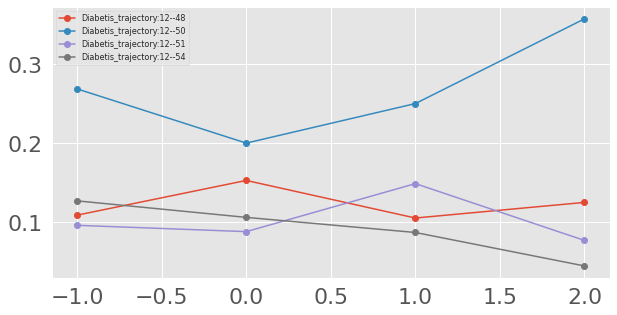

In [121]:
from scipy.stats import chi2_contingency

# Attempt to reproduce the figure from the article - global analysis

# global analysis of connection between readmission prob vs A1Cvals or predicted A1Cvals

#groups = ['all','Diabetis','Circulatory','Respiratory']
groups = ['Diabetis']
#groups = ['all']
#groups = ['Circulatory']
mean_vals = {}
std_vals = {}

#cluster_type = 'segment'
cluster_type = 'trajectory'
#cluster_type = 'all'
selected_trajectories = [48,50,51,54]

if cluster_type == 'trajectory':
    clusters = PseudoTimeTraj
    if len(selected_trajectories)>0:
        clusters = [pstt for pstt in PseudoTimeTraj if pstt['Trajectory'][-1] in selected_trajectories]
elif cluster_type == 'all':
    clusters = []
    tmp = {}
    tmp['Points'] = range(len(df))
    tmp['Trajectory'] = [0]
    clusters.append(tmp)
elif cluster_type == 'segment':
    segs = np.unique(vec_labels_by_branches)
    clusters = []
    for s in segs:
        tmp = {}
        tmp['Points'] = np.where(vec_labels_by_branches==s)[0]
        tmp['Trajectory'] = [int(s)]
        clusters.append(tmp)
        
    

for group in groups:
    
    diag1 = annotation_data['diag_1']
    if group=='all':
        inds = range(len(df))
    else:
        inds = np.where(diag1==group)[0]
    print('====================================')
    print('GROUP=',group)
    print('size of the group=',len(inds))
    
    for pstt in clusters:
        
        points = pstt['Points']
        inds1 = np.array(list(set(inds)&set(points)))
        
        A1Cresult_None = df['A1Cresult_None'].to_numpy()
        A1Cresult_val = df['A1Cresult_val'].to_numpy()
        readmitted = df['readmitted'].to_numpy()
        readmitted_binary = readmitted>1

        print('\n\n==============================================================================')
        TrajName = cluster_type+':'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
        print('Trajectory=',TrajName)
        print('size of the group=',len(inds1))
        A1Cresult_None = A1Cresult_None[inds1]
        A1Cresult_val = A1Cresult_val[inds1]
        readmitted = readmitted[inds1]
        readmitted_binary = readmitted_binary[inds1]

        print('Fraction of readmitted=',np.sum(readmitted_binary)/len(inds1))

        #dft = pd.DataFrame(data={'A1Cresult_val':A1Cresult_val,'readmitted_binary':readmitted_binary})
        #sns.boxplot(data=dft,x='A1Cresult_val',y='readmitted_binary')
        lst = []
        for val in range(3):
            n = np.sum(A1Cresult_val==val)
            fract = np.sum(readmitted_binary[A1Cresult_val==val])/n
            print('A1CValue predicted',val,'=',fract,', n=',n)

        fracts_mean = []
        fracts_stds = []

        n = np.sum(A1Cresult_None==1)
        vals = readmitted_binary[A1Cresult_None==1]
        fract = np.mean(vals)
        fracts_mean.append(np.mean(vals))
        #fracts_stds.append(np.std(vals))
        fracts_stds.append(np.sqrt(fract*(1-fract)/n))
        print('A1CValue None','=',fract,' n =',n)
        for val in range(3):
            n = np.sum((A1Cresult_None==0)&(A1Cresult_val==val))
            vals = readmitted_binary[(A1Cresult_None==0)&(A1Cresult_val==val)]
            fract = np.mean(vals)
            fracts_mean.append(np.mean(vals))
            #fracts_stds.append(np.std(vals))
            fracts_stds.append(np.sqrt(fract*(1-fract)/n))
            print('A1CValue=',val,':',fract,' n =',n)

        mean_vals[group+'_'+TrajName] = fracts_mean
        std_vals[group+'_'+TrajName] = fracts_stds

        A1CVal_categorical = np.zeros(len(inds1))
        for i in range(len(inds1)):
            if A1Cresult_None[i]==1:
                A1CVal_categorical[i] = -1
            else:
                A1CVal_categorical[i] = A1Cresult_val[i]

        print('Testing multivalued A1CVal')
        d = {'A1CVal_categorical': A1CVal_categorical, 'READMITTED': readmitted_binary} 
        dftemp = pd.DataFrame(data=d)
        table = pd.crosstab(dftemp['A1CVal_categorical'], dftemp['READMITTED'])
        stat, p, dof, expected = chi2_contingency(table)
        print('p-value of chi2 test=',p,'stat=',stat)
        display(table)
        devs = (table-expected)/(table+expected)
        display(devs)
        
        print('Testing A1CVal_None (not measured=0,measured=1)')
        A1CVal_categorical = 1-A1Cresult_None        
        d = {'A1CVal_categorical': A1CVal_categorical, 'READMITTED': readmitted_binary} 
        dftemp = pd.DataFrame(data=d)
        table = pd.crosstab(dftemp['A1CVal_categorical'], dftemp['READMITTED'])
        stat, p, dof, expected = chi2_contingency(table)
        print('p-value of chi2 test=',p,'stat=',stat)
        display(table)
        devs = (table-expected)/(table+expected)
        display(devs)

        # probability of readmission in a system of groups primary diagnosis vs A1Cresult_None,A1Cresult_val or predicted values

print(std_vals)
    
plt.figure(figsize=(10,5))
for group in groups:
    for pstt in clusters:
        TrajName = cluster_type+':'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
        #plt.plot([-1,0,1,2],np.array(mean_vals[group])+np.array(std_vals[group]),'o--')
        plt.plot([-1,0,1,2],mean_vals[group+'_'+TrajName],'o-',label=group+'_'+TrajName)
plt.legend(fontsize=8)
plt.show()


[0.11684786 0.0977245  0.10145695 0.09942239]
[0.00111835 0.00423253 0.00491419 0.00331719]
[0.14724755 0.11752137 0.12837838 0.08607595]
[0.0046047  0.01488633 0.01944304 0.00631121]
[0.11811378 0.1064244  0.10965251 0.11487051]
[0.00206399 0.0078557  0.00868269 0.00651697]
[0.10639784 0.06209573 0.0690184  0.08555133]
[0.00288073 0.00868001 0.00992726 0.00862353]


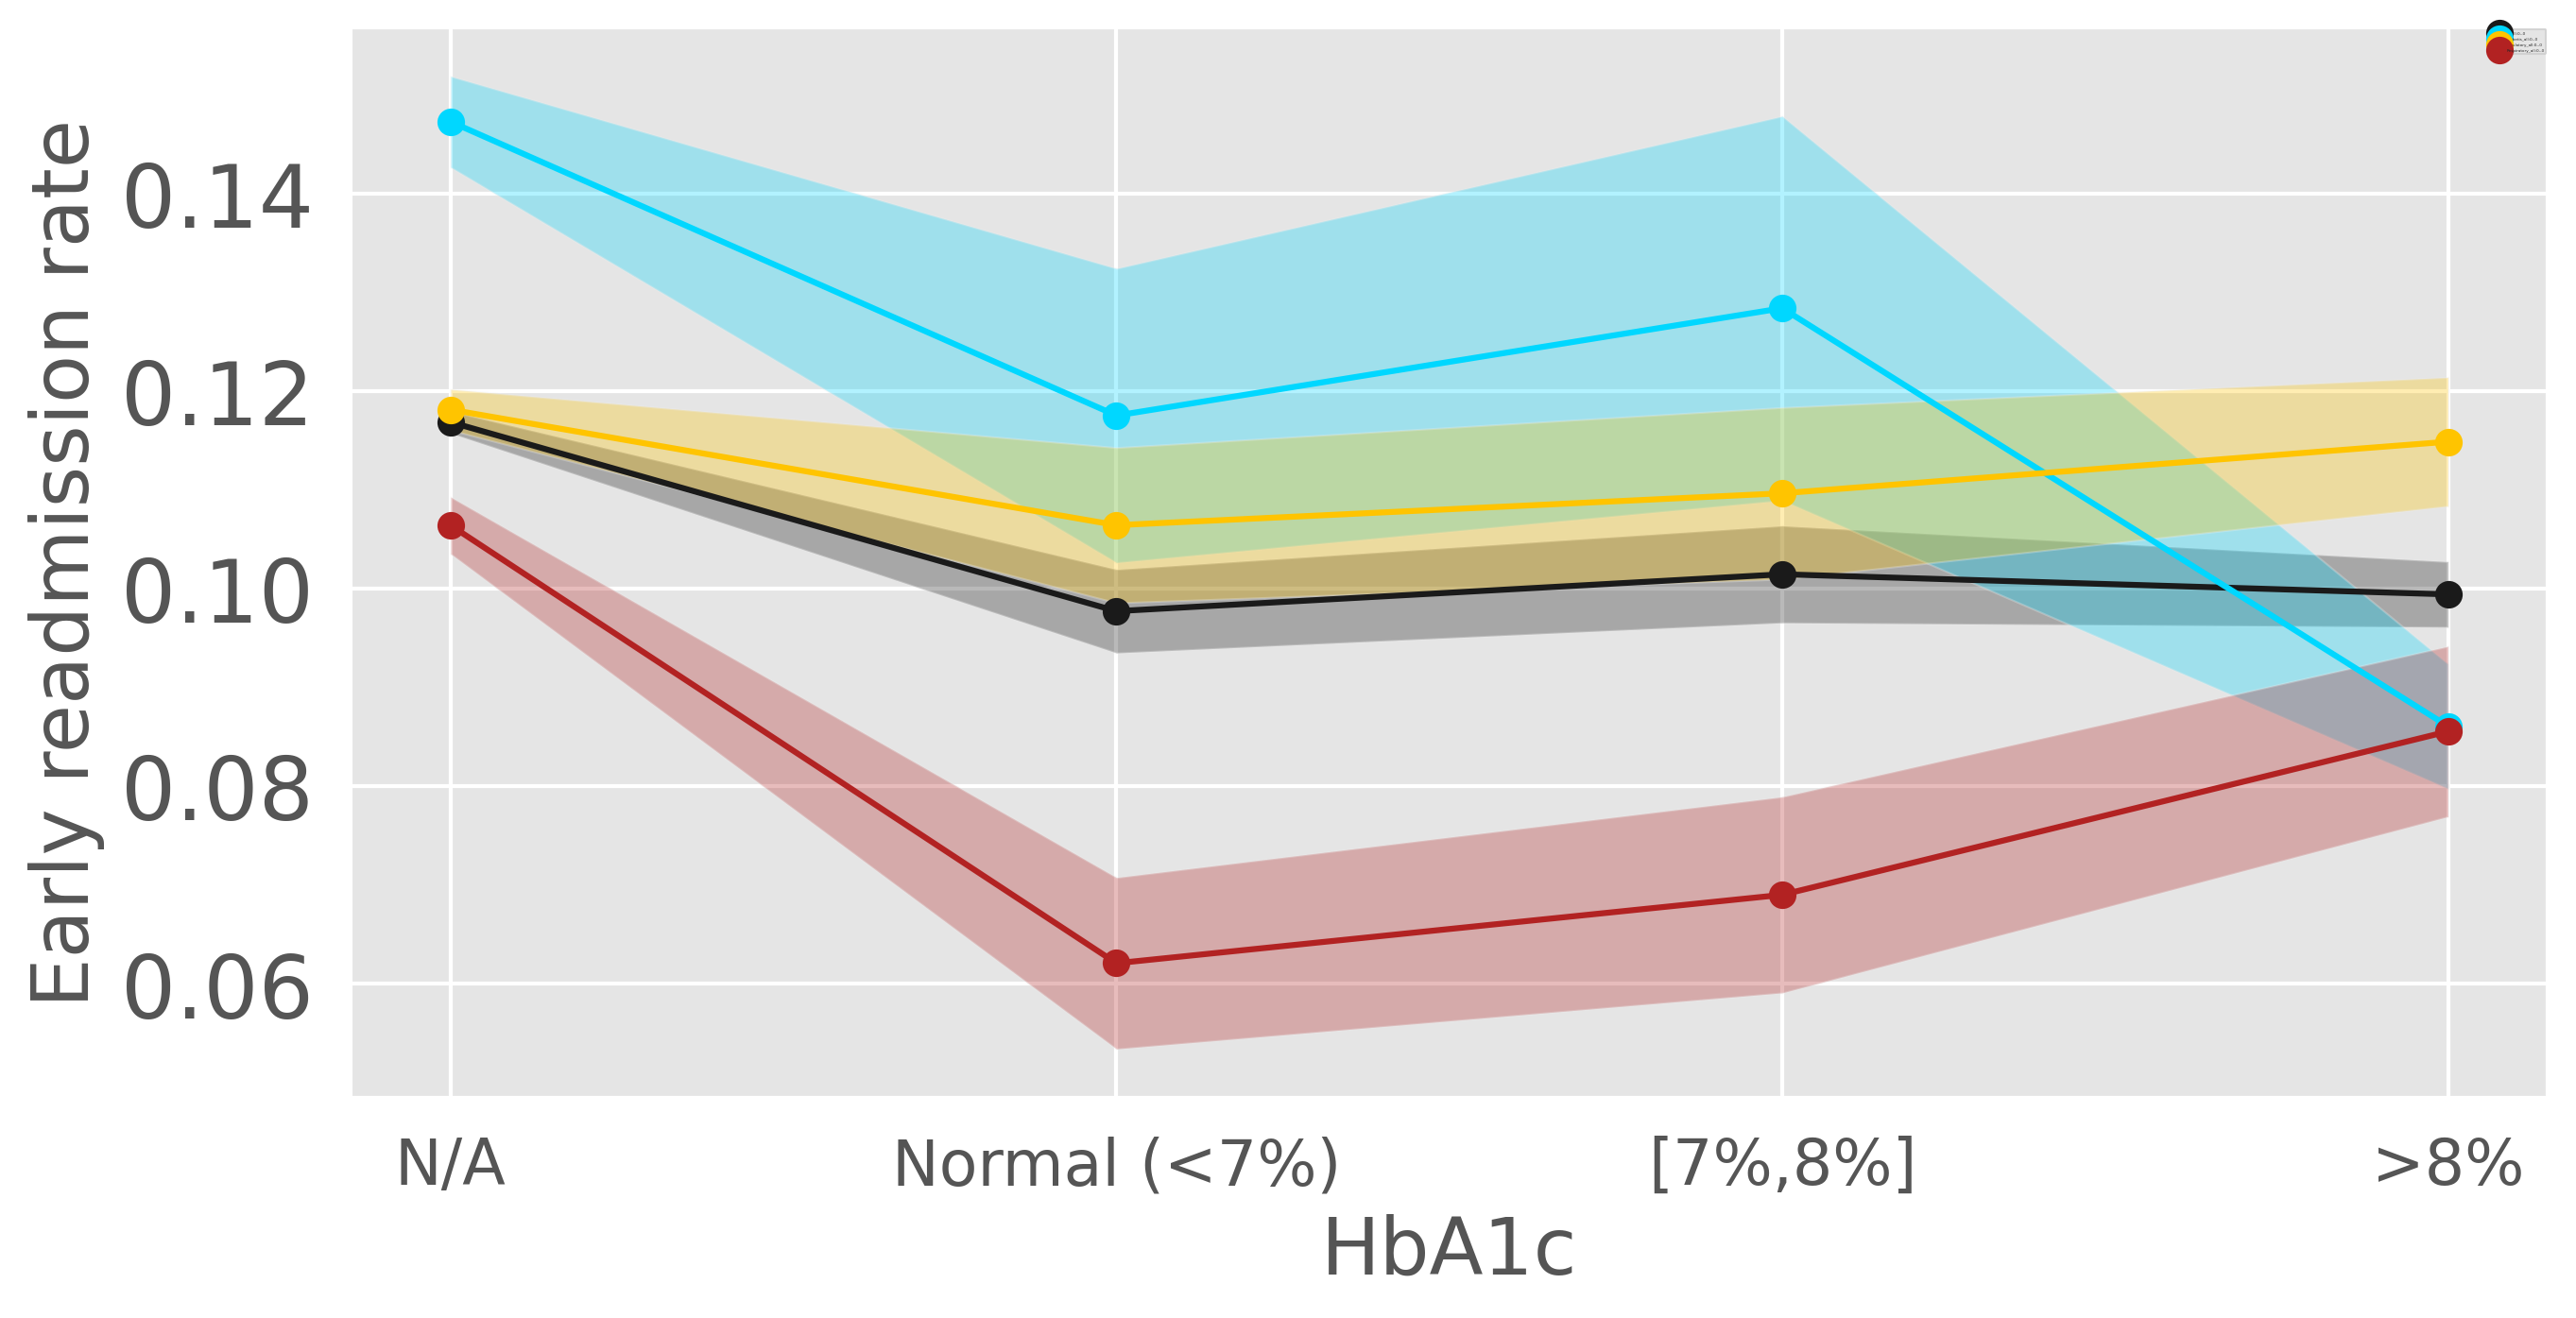

In [120]:
plt.figure(figsize=(10,5),dpi=300)
#clrs = sns.color_palette("Set1", 100)
clrs = ['k','c','y','firebrick']
i = 0
for group in groups:
    for pstt in clusters:
        TrajName = cluster_type+':'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
        #plt.plot([-1,0,1,2],np.array(mean_vals[group])+np.array(std_vals[group]),'o--')
        mn = np.array(mean_vals[group+'_'+TrajName])
        st = np.array(std_vals[group+'_'+TrajName])
        plt.plot([-1,0,1,2],mn,'o-',label=group+'_'+TrajName,color=clrs[i])
        print(mn)
        print(st)
        x = [-1,0,1,2]
        plt.fill_between(x,mn-st, mn+st ,alpha=0.3, facecolor=clrs[i])
        i = i+1
plt.legend(fontsize=0)
plt.xticks(np.arange(4)-1,labels=['N/A','Normal (<7%)','[7%,8%]','>8%'],fontsize=16)
plt.xlabel('HbA1c',fontsize=20)
plt.ylabel('Early readmission rate',fontsize=20)
plt.show()


In [ ]:
# Global logistic regression
# regressor = LogisticRegression(random_state=0,max_iter=1000,penalty='none').fit(pseudotime, vals)

size of the group Diabetis = 8661
size of the selection 1975
size of the selection 296
size of the selection 468
[0.0, 3.0, 1.0, 2.0] [96604  1975   468   296] [[0.6, 0.6, 0.6], [1, 0, 0], [1, 1, 0], [0, 1, 0]]
['white', 'red', 'blue'] [4210 3316 1135]


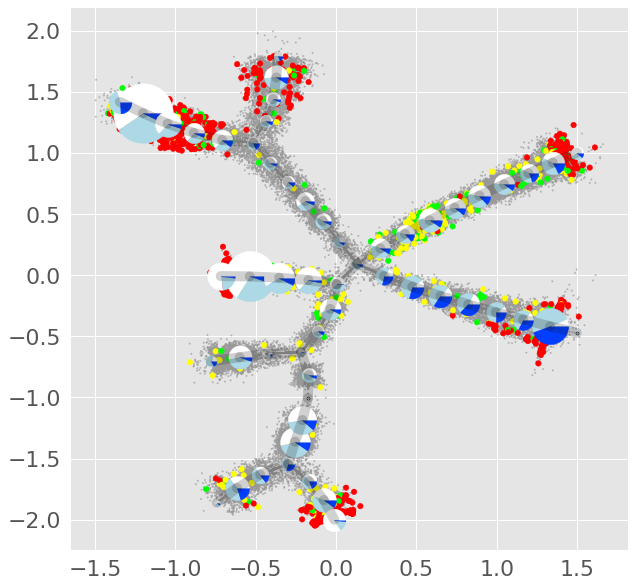

In [111]:
## visualize subset of cases, together with conditional readmission rates

reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
reload(clintraj_util)
from clintraj_util import get_colorseq_for_column

diag1 = annotation_data['diag_1']
group = 'Diabetis'
inds = np.where(diag1==group)[0]
print('size of the group',group,'=',len(inds))

A1Cresult_None = df['A1Cresult_None'].to_numpy()
A1Cresult_val = df['A1Cresult_val'].to_numpy()
readmitted = df['readmitted'].to_numpy()
readmitted_binary = readmitted>1

points = np.where((A1Cresult_None==0)&(A1Cresult_val==2))[0]
inds2 = np.array(list(set(inds)&set(points)))
print('size of the selection',len(inds2))
points = np.where((A1Cresult_None==0)&(A1Cresult_val==1))[0]
inds1 = np.array(list(set(inds)&set(points)))
print('size of the selection',len(inds1))
points = np.where((A1Cresult_None==0)&(A1Cresult_val==0))[0]
inds0 = np.array(list(set(inds)&set(points)))
print('size of the selection',len(inds0))


point_selection = np.zeros(len(df))
point_selection[inds0] = 1
point_selection[inds1] = 2
point_selection[inds2] = 3

title_font_size=20
point_size =2

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
    
color_seq = [[0.6, 0.6, 0.6],[1, 0, 0],[1, 1 , 0],[0,1,0]]
    
temp_df = pd.DataFrame(data={'SELECTION':point_selection})
color_annot, vals_unique, vals_unique_freq = get_colorseq_for_column(temp_df,'SELECTION',color_seq=color_seq)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                          Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,highlight_subset=list(set(inds1)|set(inds2)|set(inds0)),
                           Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,Big_Point_Size=30,
                          Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.05,percentile_contraction=50,
                          Transparency_Alpha_points=0.6)

print(vals_unique,vals_unique_freq,color_seq)

#plt.scatter(tree_extended['NodePositions2D'][:,0],tree_extended['NodePositions2D'][:,1],s=400)

#vals = list(annotation_data[feature].replace({'Respiratory':'blue','Digestive':'blue','Injury':'blue'}))
#add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['w','b','g','r'],scale=0.3)

vals = list(df.iloc[inds]['readmitted'].replace({0:'white',1:'red',2:'blue'}))
add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['w','lightblue','b'],partition[inds],scale=3)

plt.savefig(dataset_name+'_principal_tree_readmission_Diabetis.png', format='png', dpi=400)
plt.show()